In [1]:
import os
import requests
import pandas as pd
from datetime import date, datetime
from pprint import pprint
import csv
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
import json
from math import *
import seaborn as sns
import geopy.distance
from babel.dates import format_date
import meteo
import data_api
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import folium


## 1. Exploraration des données
#### Objectif:
- Comprendre le mieux les données issues de l'API
- Faire une première comparaison avec le capteur de référence
#### Checklist de base
- **variable target**: les mesures 
- **lignes et colonnes**: (36706, 12) pour des données entre "2021-01-01"-->"2022-03-01"
- **type de variables**: qualitatives: 4, quantitatives: 8
- **analyse des valeurs manquantes**: pas de NaN
- **visualisation de la target**: les valeurs des mesures sont équilibrées en effet, il y a 4 mesures et chacune a 25% des valeurs dans le dataset
- **relation entre variables/target**: 

Il y a que 2 sites sur 49 qui ont plus que 2 capteurs et avec un station de référence et qui sont: **FR15043** et **FR15038**.
La distance séparant ces deux sites est de 3.01 km

Parmi 49 sites de mesures de PM2.5, il y a 39 sites qui ont au moins deux microcapteurs colocalisés. 2 sites qui n'ont pas de mesures. 6 sites ayant un seul microcapteur.

Algorithme de classification des sites par leur proximité à un des deux sites ayant une station de référence.

In [2]:
path = os.getcwd()
key = 'https://api.atmo-aura.fr/api/v1/'
api_token='fb0d9e1ded2c253ba5be4726799333df'

In [4]:
def get_merged_by_one(data,mesure_id):
    """
    Récupère un tableau combinant les valeurs des mesures du capteur de référence et d'un microcapteur spécifique.
    Cette fonction filtre les données pour extraire les mesures du capteur de référence (type "Analyseur Air") 
    ainsi que celles d’un microcapteur spécifique, identifiées par son `mesure_id`. 
    Les deux jeux de données sont fusionnés sur la colonne "date" pour permettre une comparaison directe des valeurs.

    Args:
        data (pd.DataFrame): 
            Le tableau de données contenant les mesures des capteurs, incluant au minimum les colonnes 
            'date', 'valeur', 'type_appareil_label', et 'mesure_id'.
        mesure_id (str): 
            Identifiant unique du microcapteur dont les mesures doivent être récupérées et comparées à celles du capteur de référence.

    Returns:
        pd.DataFrame: 
            Un tableau contenant :
            - 'date' : La date commune aux deux jeux de mesures.
            - 'valeur_reference' : Les valeurs du capteur de référence pour chaque date.
            - 'valeur_{mesure_id}' : Les valeurs du microcapteur spécifique pour chaque date.
    """
    reference = data.loc[data['type_appareil_label']=='Analyseur Air' ,['date', 'valeur','type_appareil_label']]
    microcapteur = data.loc[data['mesure_id']==mesure_id,['date', 'valeur','type_appareil_label']]
    merged = pd.merge(reference, microcapteur, on='date', how='inner', suffixes=('_reference', f'_{mesure_id}'))
    merged = merged[['date','valeur_reference',f'valeur_{mesure_id}']]
    return merged

In [ ]:
def get_merged(data):
    dfs = [] # liste des dataframe
    reference_index = None
    for i, mesure in enumerate(data['mesure_id'].unique()):
        if mesure[-2:] == '11':
            reference_index = i
        microcapteur = data.loc[data['mesure_id'] == mesure, ['date', 'valeur','type_appareil_label','mesure_id','season']]
        dfs.append(microcapteur)
    
    if reference_index is not None:
        reference = dfs.pop(reference_index)
        dfs.insert(0, reference)
    
    merged = dfs[0]
    for i in range(1, len(dfs)):
        mesure_id = dfs[i]['mesure_id'].unique()[0]
        merged = pd.merge(merged, dfs[i], on='date', how='inner', suffixes=('', f'_{mesure_id}'))
        # merged = df = pd.concat((merged, dfs[i]), axis=1)
    return merged

In [5]:
def get_merged_data_meteo(hum_data,temp_data):
    """
    Récupérer un tableau combinant les valeurs des mesures de température et de l'humidité.
    Les deux jeux de données sont fusionnés sur la colonne "date" pour permettre le même nombre de valeurs.

    Args:
        hum_data (DataFrame): tableau contenant les dates et les valeurs d'humidité en % 
        temp_data (_int_): tableau contenant les dates et les valeurs de température en °C

    Returns:
        Dataframe: tableau regrouppant les valeurs d'humidité et la température
    """
    merge = pd.merge(hum_data, temp_data, on='date', how='inner', suffixes=('_hum', f'_temp'))
    return merge

In [ ]:
def get_metrics_per_week(data,seuil=0.0,freq='W'):
    """
    Cette fonction permet d'avoir le coefficient de détermination par semaine pour chaque microcapteur avec le capteur de référence 
    Args:
        data (DataFrame): les données de tous les microcapteurs dans le même site

    Returns:
        DataFrame: DataFrame contenant les coefficients de détermination par semaine pour chaque microcapteur
    """
    # encoder = LabelEncoder()
    # data['code'] = encoder.fit_transform(data['mesure_id'])
    data['date'] = pd.to_datetime(data['date'])
    merge_data = get_merged(data)
    frequency = [g for n, g in merge_data.set_index('date').groupby(pd.Grouper(freq=freq))]
    dictio = {'semaine':[],'mesure_id':[],'type appareil':[],'r2':[],'Median_absolute_error':[],'Mean_absolute_error':[],'RMSE':[],'MBE':[],'CV':[]}

    for i, freq_data in enumerate(frequency, start=1):
        if len(freq_data) >= 7*24*seuil:
            semaine = i
            Y = freq_data['valeur'].values.reshape(-1, 1)
            for mesure in data['mesure_id'].unique():
                if mesure[-2:] == '11':
                    continue
                type_appareil = data.loc[data['mesure_id'] == mesure, 'type_appareil_label'].iloc[0]
                X = freq_data[f'valeur_{mesure}'].values.reshape(-1, 1)
                model = LinearRegression()
                model.fit(X, Y)
                Z = model.predict(X)
                mbe = np.sum(Y-Z)/len(Y)
                cv = (np.std(X))/(np.mean(X))
                deter = model.score(Z, Y)
                error = median_absolute_error(Z,Y)
                error_predicted = mean_absolute_error(Z,Y)
                error_squared = mean_squared_error(Z,Y)
                dictio['semaine'].append(semaine)
                dictio['mesure_id'].append(mesure)
                dictio['type appareil'].append(type_appareil)
                dictio['r2'].append(deter)
                dictio['Median_absolute_error'].append(error)
                dictio['Mean_absolute_error'].append(error_predicted)
                dictio['RMSE'].append(np.sqrt(error_squared))
                dictio['MBE'].append(mbe)
                dictio['CV'].append(cv)
    df = pd.DataFrame(data=dictio)
    return df

In [ ]:
def apply_calibration(data,mesure_id,seuil=0.0,freq='W'):
    data['date'] = pd.to_datetime(data['date'])
    if mesure_id not in data['mesure_id'].unique():
        print('Entrez la bonne mesure ')
    merged = get_merged(data)
    frequency = [g for n, g in merged.set_index('date').groupby(pd.Grouper(freq=freq))]
    dict = {'semaine': [],'r2': [],'r2_après_calibration': [],'mesure_id':[] }
    for i,freq_data in enumerate(frequency,start=1):
        if len(freq_data) >= 7*24*seuil:
            semaine = i
            model = LinearRegression()
            X = freq_data[f'valeur_{mesure_id}'].values.reshape(-1,1)
            Y = freq_data['valeur'].values.reshape(-1,1)
            model.fit(X,Y)
            for mesure in data['mesure_id'].unique():
                if mesure[-2:] == '11' or mesure == mesure_id:
                    continue
                x = freq_data[f'valeur_{mesure}'].values.reshape(-1,1)
                deter_1 = model.score(x,Y)
                Z = model.predict(x)
                deter = model.score(Z,Y)
                dict['semaine'].append(semaine)
                dict['r2'].append(deter_1)
                dict['r2_après_calibration'].append(deter)
                dict['mesure_id'].append(mesure)
    df = pd.DataFrame(data=dict)
    return df        

In [ ]:
def get_anomalies(data,mesure,row=4,column=4):
    
    data['date'] = pd.to_datetime(data['date'])
    if mesure not in data['mesure_id'].unique():
        return None
    data_merged = get_merged(data)
    data_merged.set_index('date',inplace=True)
    months = [g for n, g in data_merged.groupby(pd.Grouper(freq='M'))]
    # Déterminer le nombre de sous-graphiques
    num_months = len(months)
    # Création de la figure et des sous-graphiques
    fig, axes = plt.subplots(row, column, figsize=(20, 12), constrained_layout=True)  # 4x4 pour un maximum de 16 sous-graphiques
    axes = axes.flatten()  # Aplatir les axes pour un accès facile

    for i, month in enumerate(months):
    # month = month.resample('H').mean()
        ax = axes[i]
        difference = month['valeur_reference'] - month[f'valeur_{mesure}']
        ax.plot(difference, label=mesure)
        mean = difference.mean()
        std = difference.std()
        ax.axhline(y=mean, color='r', linestyle='--', label='Différence moyenne')
        ax.axhline(y=mean + 2*std, color='g', linestyle='--', label='différence + std')
        ax.axhline(y=mean - 2*std, color='b', linestyle='--', label='différence - std')
        ax.set_xlabel('Temps')
        ax.set_ylabel('Concentrations en µg/m3')
        month_name = format_date(month.index[0], format='MMMM yyyy', locale='fr_FR')
        ax.set_title(f"Différence en {month_name.capitalize()}")
        ax.tick_params(axis='x', rotation=45)
        if i == 0:
            ax.legend()  # Ajouter la légende seulement au premier subplot pour éviter les répétitions

    # Supprimer les sous-graphiques vides si num_months < 16
    for j in range(num_months, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [ ]:
def get_difference(data,mesure,row=4,column=4):
    data['date'] = pd.to_datetime(data['date'])
    data_merged = get_merged(data)
    data_merged['diff'] = data_merged['valeur'] - data_merged[f'valeur_{mesure}']
    data_merged.set_index('date',inplace=True)
    months = [g for n, g in data_merged.groupby(pd.Grouper(freq='M'))]
    # Déterminer le nombre de sous-graphiques
    num_months = len(months)
    # Création de la figure et des sous-graphiques
    fig, axes = plt.subplots(row, column, figsize=(20, 12), constrained_layout=True)  # 4x4 pour un maximum de 16 sous-graphiques
    axes = axes.flatten()  # Aplatir les axes pour un accès facile

    for i, month in enumerate(months):
        model = LinearRegression()
        X = month[f'valeur_{mesure}'].values.reshape(-1,1)
        Y = month['valeur'].values.reshape(-1,1)
        model.fit(X,Y)
        Z = model.predict(X)
        ax = axes[i]
        ax.plot(month['diff'], label=f'ref/{mesure}')
        ax.plot(month.index,Y-Z, label=f'ref/prediction')
        ax.axhline(y=month['diff'].mean(),label='erreur moyenne',linestyle='--',c='black')
        ax.axhline(y=(Y-Z).mean(),label='erreur moyenne corrigée',linestyle='--',c='g')
        # ax.axhline(y=0, color='r', linestyle='--', label='différence idéale')
        ax.set_xlabel('Temps')
        ax.set_ylabel('Différence de concentrations en µg/m3')
        month_name = format_date(month.index[0], format='MMMM yyyy', locale='fr_FR')
        ax.set_title(f"Différence en {month_name.capitalize()}")
        ax.tick_params(axis='x', rotation=45)
        if i == 0:
            ax.legend() 
    # Supprimer les sous-graphiques vides si num_months < 16
    for j in range(num_months, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [ ]:
def get_bias_Rh(data,mesure,row=4,column=4,freq='M'):
    # data_merged = get_merged(data)
    data['diff'] = data['valeur_reference'] - data[f'valeur_{mesure}']
    data.set_index('date',inplace=True)
    months = [g for n, g in data.groupby(pd.Grouper(freq=freq))]
    # Déterminer le nombre de sous-graphiques
    num_months = len(months)
    # Création de la figure et des sous-graphiques
    fig, axes = plt.subplots(row, column, figsize=(20, 12), constrained_layout=True)  # 4x4 pour un maximum de 16 sous-graphiques
    axes = axes.flatten()  # Aplatir les axes pour un accès facile

    for i, month in enumerate(months):
        model = LinearRegression()
        X = month[f'valeur_{mesure}'].values.reshape(-1,1)
        Y = month['diff'].values.reshape(-1,1)
        model.fit(X,Y)
        Z = model.predict(X)
        print(model.score(X,Y))
        ax = axes[i]
        ax.scatter(month[f'valeur_{mesure}'],month['diff'], label=f'{mesure}')
        ax.plot(month[f'valeur_{mesure}'],Z, label=f'ref/prediction',c='r')
        ax.axhline(y=0,linestyle='--',c='g')
        # ax.axhline(y=0, color='r', linestyle='--', label='différence idéale')
        ax.set_xlabel(f'Concentration de {mesure}')
        ax.set_ylabel('Différence de concentrations en µg/m3')
        month_name = format_date(month.index[0], format='MMMM yyyy', locale='fr_FR')
        ax.set_title(f"Différence en {month_name.capitalize()}")
        ax.tick_params(axis='x', rotation=45)
        if i == 0:
            ax.legend() 
    # Supprimer les sous-graphiques vides si num_months < 16
    for j in range(num_months, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [ ]:
def get_Rh(data,mesure,row=4,column=4):
    # data_merged = get_merged(data)
    data['diff'] = data['valeur_reference'] - data[f'valeur_{mesure}']
    # data.set_index('date',inplace=True)
    months = [g for n, g in data.groupby(pd.Grouper(freq='M'))]
    # Déterminer le nombre de sous-graphiques
    num_months = len(months)
    # Création de la figure et des sous-graphiques
    fig, axes = plt.subplots(row, column, figsize=(30, 12), constrained_layout=True)  # 4x4 pour un maximum de 16 sous-graphiques
    axes = axes.flatten()  # Aplatir les axes pour un accès facile

    for i, month in enumerate(months):
        model = LinearRegression()
        X = month['valeur_hum'].values.reshape(-1,1)
        Y = month['diff'].values.reshape(-1,1)
        model.fit(X,Y)
        Z = model.predict(X)
        ax = axes[i]
        ax.scatter(month['valeur_hum'],month['diff'], label='T')
        ax.plot(month['valeur_hum'],Z, label=f'ref-prediction',c='r')
        ax.axhline(y=0,linestyle='--',c='g')
        # ax.axhline(y=0, color='r', linestyle='--', label='différence idéale')
        ax.set_xlabel('%RH')
        ax.set_ylabel('Différence de concentrations en µg/m3')
        month_name = format_date(month.index[0], format='MMMM yyyy', locale='fr_FR')
        ax.set_title(f"Différence en {month_name.capitalize()}")
        ax.tick_params(axis='x', rotation=45)
        if i == 0:
            ax.legend() 
    # Supprimer les sous-graphiques vides si num_months < 16
    for j in range(num_months, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [ ]:
def get_multi_regression(data,meteo_api,mesure,freq='W'):
    data['date'] = pd.to_datetime(data['date'])
    merged = get_merged(data)
    data_complet = pd.merge(merged,meteo_api,on='date',how='inner')
    data_complet.set_index('date',inplace=True)
    months = [g for n, g in data_complet.groupby(pd.Grouper(freq=freq))]
    # Déterminer le nombre de sous-graphiques
    num_months = len(months)
    # Création de la figure et des sous-graphiques
    fig, axes = plt.subplots(4, 4, figsize=(20, 12), constrained_layout=True)  # 4x4 pour un maximum de 16 sous-graphiques
    axes = axes.flatten()  # Aplatir les axes pour un accès facile

    for i, month in enumerate(months):
        model = make_pipeline(RobustScaler(),LinearRegression())
        X1 = month[f'valeur_{mesure}'].values.reshape(-1,1)
        # X1_transform = RobustScaler().fit_transform(X1)
        X_hum = month['valeur_hum'].values.reshape(-1,1)
        X_temp = month['valeur_temp'].values.reshape(-1,1)
        ones_column = np.ones((X1.shape[0], 1))
        X = np.hstack((X1,X_temp,X_hum,ones_column))
        Y = month['valeur'].values.reshape(-1,1)
        # Y_transform = RobustScaler().fit_transform(Y)
        
        model.fit(X,Y)
        Z = model.predict(X)
        print(model.score(X,Y))
        ax = axes[i]
        ax.scatter(X1,Y, label=f'ref/{mesure}')
        ax.plot(X1,Z,c='r',label=f'ref/prediction')
        ax.set_xlabel(f'Concentrations {mesure} en µg/m3')
        ax.set_ylabel('Concentrations reference en µg/m3')
        month_name = format_date(month.index[0], format='MMMM yyyy', locale='fr_FR')
        ax.set_title(f"en {month_name.capitalize()}")
        ax.tick_params(axis='x', rotation=45)
        if i == 0:
            ax.legend() 
    # Supprimer les sous-graphiques vides si num_months < 16
    for j in range(num_months, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

In [ ]:
def get_simple_regression(data,meteo_api,mesure,freq='W'):
    data['date'] = pd.to_datetime(data['date'])
    merged = get_merged(data)
    data_complet = pd.merge(merged,meteo_api,on='date',how='inner')
    data_complet.set_index('date',inplace=True)
    months = [g for n, g in data_complet.groupby(pd.Grouper(freq=freq))]
    # Déterminer le nombre de sous-graphiques
    num_months = len(months)
    # Création de la figure et des sous-graphiques
    fig, axes = plt.subplots(4, 4, figsize=(20, 12), constrained_layout=True)  # 4x4 pour un maximum de 16 sous-graphiques
    axes = axes.flatten()  # Aplatir les axes pour un accès facile

    for i, month in enumerate(months):
        model = make_pipeline(RobustScaler(),LinearRegression())
        # theta_init = np.random.randn(4,1)
        X = month[f'valeur_{mesure}'].values.reshape(-1,1)
        Y = month['valeur'].values.reshape(-1,1)
        model.fit(X,Y)
        # theta, cost_history = gradient_descent(X,Y,theta_init,learning_rate,n_iterations)
        # Z = model(X,theta)
        Z = model.predict(X)
        ax = axes[i]
        ax.scatter(X,Y, label=f'ref/{mesure}',c='r')
        ax.plot(X,Z, label=f'ref/prediction')
        ax.set_xlabel(f'Concentrations {mesure} en µg/m3')
        ax.set_ylabel('Concentrations reference en µg/m3')
        month_name = format_date(month.index[0], format='MMMM yyyy', locale='fr_FR')
        print(f'for {month_name} r2={model.score(X,Y)}')
        ax.set_title(f"en {month_name.capitalize()}")
        ax.tick_params(axis='x', rotation=45)
        if i == 0:
            ax.legend() 
    # Supprimer les sous-graphiques vides si num_months < 16
    for j in range(num_months, len(axes)):
        fig.delaxes(axes[j])

    plt.show()

* Extraction des données météorologiques issues du FR15043

In [6]:
temp_sites = data_api.get_site_id(key,api_token,'38','temperature') 
temp_mesures = meteo.get_mesure_id_temp_hum(key,api_token,'FR15043','temperature','38')
hum_sites = data_api.get_site_id(key,api_token,'38',f'humidit%C3%A9+relative')
hum_mesures = meteo.get_mesure_id_temp_hum(key,api_token,'FR15043',f'humidit%C3%A9+relative','38')

In [ ]:
pol_sites = data_api.get_site_id(key,api_token,'38','PM2.5') 
# Voir les mesures qui sont sur le site FR15043
pol_mesures = data_api.get_mesure_id(key,api_token,'FR15043','PM2.5','38')

In [ ]:
## Récupérer les tableau de données météorologiques pour l'année 2021
data_temp = meteo.get_csv_temp_hum(key, 'horaire', path, api_token, 'temperature', '2021-01-01','2022-01-01','38','FR15043','FR15043_54_57_4',period=5)
data_temp.drop_duplicates(keep = 'first', inplace=True)
data_temp['date'] = pd.to_datetime(data_temp['date'])
data_hum = meteo.get_csv_temp_hum(key, 'horaire', path, api_token,f'humidit%C3%A9+relative', '2021-01-01','2022-01-01','38','FR15043','FR15043_58_57_4',period=5)
data_hum.drop_duplicates(keep = 'first', inplace=True)
data_hum['date'] = pd.to_datetime(data_hum['date'])
meteo_api_2021 = get_merged_data_meteo(data_hum,data_temp)

In [9]:
## Récupérer les tableau de données météorologiques pour l'année 2022
data_temp = meteo.get_csv_temp_hum(key, 'horaire', path, api_token, 'temperature', '2022-01-01','2023-01-01','38','FR15043','FR15043_54_57_4',period=5)
data_temp.drop_duplicates(keep = 'first', inplace=True)
data_temp['date'] = pd.to_datetime(data_temp['date'])
data_hum = meteo.get_csv_temp_hum(key, 'horaire', path, api_token,f'humidit%C3%A9+relative', '2022-01-01','2023-01-01','38','FR15043','FR15043_58_57_4',period=5)
data_hum.drop_duplicates(keep = 'first', inplace=True)
data_hum['date'] = pd.to_datetime(data_hum['date'])
meteo_api_2022 = get_merged_data_meteo(data_hum,data_temp)

In [10]:
## Récupérer les tableau de données météorologiques pour l'année 2023 et 2024
data_temp = meteo.get_csv_temp_hum(key, 'horaire', path, api_token, 'temperature', '2023-01-01','2024-04-01','38','FR15043','FR15043_54_57_4',period=5)
data_temp.drop_duplicates(keep = 'first', inplace=True)
data_temp['date'] = pd.to_datetime(data_temp['date'])
data_hum = meteo.get_csv_temp_hum(key, 'horaire', path, api_token,f'humidit%C3%A9+relative', '2023-01-01','2024-04-01','38','FR15043','FR15043_58_57_4',period=5)
data_hum.drop_duplicates(keep = 'first', inplace=True)
data_hum['date'] = pd.to_datetime(data_hum['date'])
meteo_api_2023 = get_merged_data_meteo(data_hum,data_temp)

Tout le travail se concentrera sur le site FR15043 à Grenoble

* Extraction des valeurs de PM10 et PM2.5 sur une période d'une année

In [24]:
mesure_1 = 'FR15043_39_57_3'
mesure_2 = 'FR15043_39_57_4'
mesure_3 = 'FR15043_39_57_5'
mesure_c1 = 'FR15043_39_57_3_C1'

In [11]:
#site: FR15043 
data_2021 = data_api.get_csv(key,'horaire', path, api_token,'PM2.5','2021-01-01','2022-01-01','38','FR15043')
# Elimination des colonnes inutiles
data_2021 = data_2021.drop(['validation','id_poll_ue','label_court_unite','unite','site_id','label_polluant','label_unite','code_polluant'],axis=1)
data_2021.drop_duplicates(keep = 'first', inplace=True)
# Rendre la colonne date en format datetime
data_2021['date'] = pd.to_datetime(data_2021['date'],utc=False)
# str[0:10] + ' ' + data['date'].str[11:-1]
value_counts = data_2021['mesure_id'].value_counts(normalize=True)
data_2021 = data_2021[data_2021['mesure_id'].isin(value_counts[value_counts > 0.03].index)]

encoder = LabelEncoder()
data_2021['code'] = encoder.fit_transform(data_2021['mesure_id'])

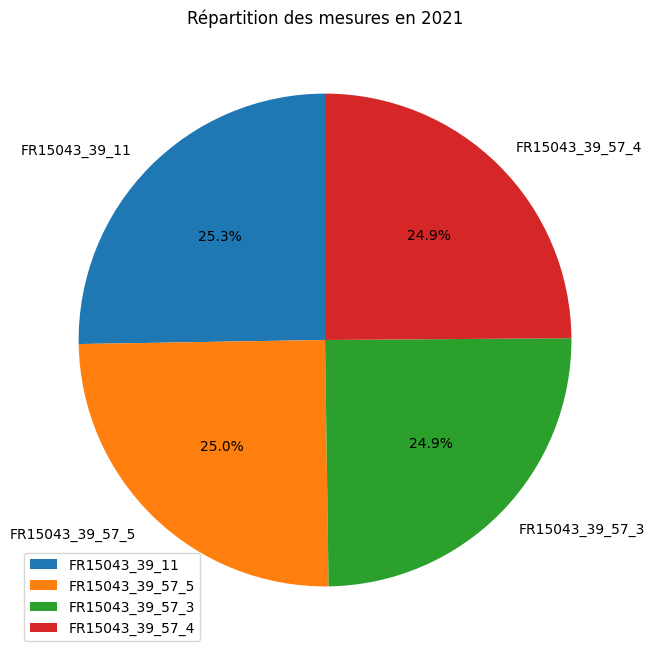

In [ ]:
# Répartition des données entre les capteurs
counts = data_2021['mesure_id'].value_counts()
percentages = counts / counts.sum() * 100

# Création du graphique
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
year = data_2021['date'].dt.year.iloc[0]
plt.legend()
plt.title(f'Répartition des mesures en {year}')
plt.show()

In [14]:
#site: FR15043 
data_2022 = data_api.get_csv(key,'horaire', path, api_token,'PM2.5','2022-01-01','2023-01-01','38','FR15043')
# Elimination des colonnes inutiles
data_2022 = data_2022.drop(['validation','id_poll_ue','label_court_unite','unite','site_id','label_polluant','label_unite','code_polluant'],axis=1)
data_2022.drop_duplicates(keep = 'first', inplace=True)
# Rendre la colonne date en format datetime
data_2022['date'] = pd.to_datetime(data_2022['date'])
# str[0:10] + ' ' + data['date'].str[11:-1]
value_counts = data_2022['mesure_id'].value_counts(normalize=True)
# data_1 = data_1[data_1['mesure_id'].isin([value_counts > 0.03].index)]

encoder = LabelEncoder()
data_2022['code'] = encoder.fit_transform(data_2022['mesure_id'])

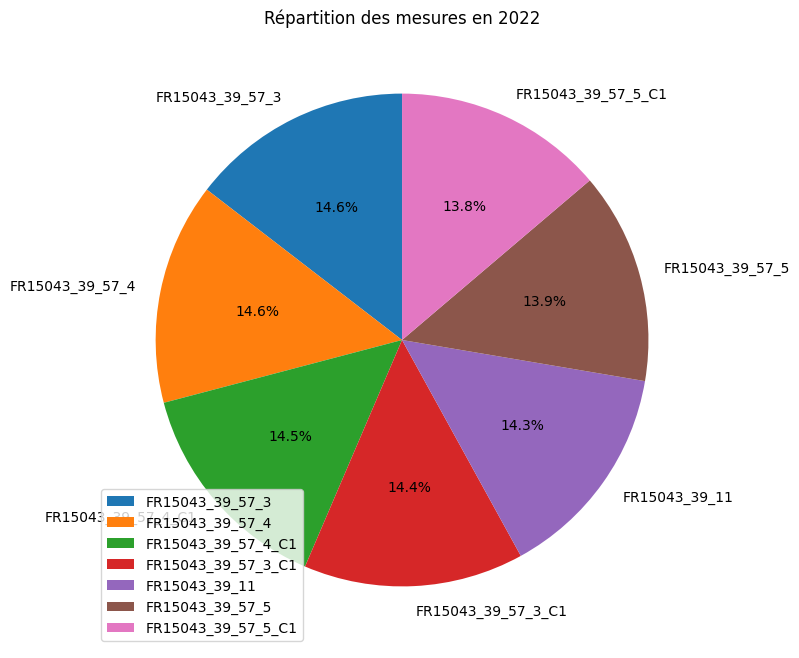

In [19]:
counts = data_2022['mesure_id'].value_counts()
percentages = counts / counts.sum() * 100

# Création du graphique
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
year = data_2022['date'].dt.year.iloc[0]
plt.legend()
plt.title(f'Répartition des mesures en {year}')
plt.show()

In [20]:
#site: FR15043 
data_2023 = data_api.get_csv(key,'horaire', path, api_token,'PM2.5','2023-01-01','2024-04-01','38','FR15043')
# Elimination des colonnes inutiles
data_2023 = data_2023.drop(['validation','id_poll_ue','label_court_unite','unite','site_id','label_polluant','label_unite','code_polluant'],axis=1)
data_2023.drop_duplicates(keep = 'first', inplace=True)
# Rendre la colonne date en format datetime
data_2023['date'] = pd.to_datetime(data_2023['date'])
# str[0:10] + ' ' + data['date'].str[11:-1]
value_counts = data_2023['mesure_id'].value_counts(normalize=True)
# data_1 = data_1[data_1['mesure_id'].isin(value_counts[value_counts > 0.03].index)]

encoder = LabelEncoder()
data_2023['code'] = encoder.fit_transform(data_2023['mesure_id'])

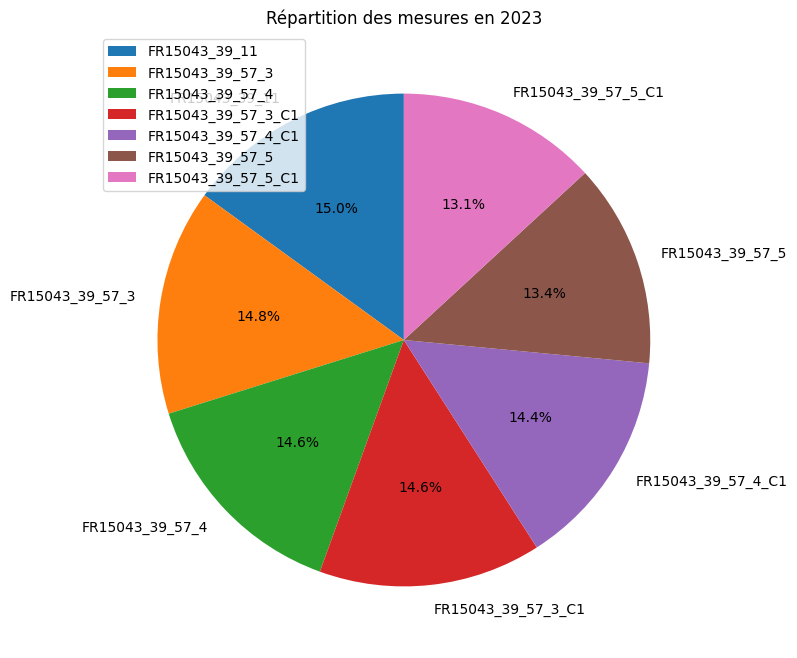

In [21]:
counts = data_2023['mesure_id'].value_counts()
percentages = counts / counts.sum() * 100

# Création du graphique
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
year = data_2023['date'].dt.year.iloc[0]
plt.legend()
plt.title(f'Répartition des mesures en {year}')
plt.show()

In [22]:
def get_complet(data,meteo_api,mesure):
    """
    Obtenir un tableau combiné regroupant les valeurs d'un capteur spécifique et les données météorologiques sur les mêmes dates.
    Cette fonction fusionne les données d'un capteur spécifique avec les données météorologiques disponibles pour les mêmes dates. 
    Elle enrichit également le tableau final en ajoutant des colonnes supplémentaires pour extraire les informations temporelles 
    telles que le mois, le jour et l'année.

    Args:
        data (pd.DataFrame): 
            Tableau contenant les données des capteurs, incluant au minimum les colonnes 'date', 'valeur', 
            et toute information nécessaire pour identifier les mesures d'un capteur spécifique.
        meteo_api (pd.DataFrame): 
            Tableau contenant les données météorologiques, incluant une colonne 'date' commune avec `data`.
        mesure (int): 
            Identifiant unique du capteur dont les données doivent être fusionnées avec les données météorologiques.

    Returns:
        pd.DataFrame: 
            Un tableau combiné contenant :
            - Les valeurs du capteur spécifique.
            - Les données météorologiques associées.
            - Des colonnes dérivées : 'mois', 'jour' (nom du jour), 'annee'.
    """
    merged = get_merged_by_one(data,mesure)
    merged['date'] = pd.to_datetime(merged['date'])
    data_complet = pd.merge(merged,meteo_api,on='date',how='inner')
    data_complet.set_index('date',inplace=True)
    data_complet['mois'] = data_complet.index.month_name()
    data_complet['jour'] = data_complet.index.day_name()
    data_complet['annee'] = data_complet.index.year
    if (data_complet[-1:]['annee'].values[0] != data_complet[-2:]['annee'].values[0]):
        data_complet = data_complet.iloc[:-1]
    else:
        return data_complet
    return data_complet

In [ ]:
# Obtenir un tableau complet pour chaque micrôcapteur avec les valeurs de concentration du polluant accompagnées des valeurs de température et humidité 
# Capteur 1
data_complet_2021_cap1 = get_complet(data_2021,meteo_api_2021,mesure_1)
data_complet_2022_cap1 = get_complet(data_2022,meteo_api_2022,mesure_1)
data_complet_2023_cap1 = get_complet(data_2023,meteo_api_2023,mesure_1)
data_complet_cap1 = pd.concat([data_complet_2021_cap1, data_complet_2022_cap1,data_complet_2023_cap1])
data_complet_cap1.drop_duplicates(keep = 'first', inplace=True)

# Capteur 2
data_complet_2021_cap2 = get_complet(data_2021,meteo_api_2021,mesure_2)
data_complet_2022_cap2 = get_complet(data_2022,meteo_api_2022,mesure_2)
data_complet_2023_cap2 = get_complet(data_2023,meteo_api_2023,mesure_2)
data_complet_cap2 = pd.concat([data_complet_2021_cap2, data_complet_2022_cap2,data_complet_2023_cap2])
data_complet_cap2.drop_duplicates(keep = 'first', inplace=True)

# Capteur 3
data_complet_2021_cap3 = get_complet(data_2021,meteo_api_2021,mesure_3)
data_complet_2022_cap3 = get_complet(data_2022,meteo_api_2022,mesure_3)
data_complet_2023_cap3 = get_complet(data_2023,meteo_api_2023,mesure_3)
data_complet_cap3 = pd.concat([data_complet_2021_cap3, data_complet_2022_cap3,data_complet_2023_cap3])
data_complet_cap3.drop_duplicates(keep = 'first', inplace=True)

# Nouveau capteur_1
data_complet_2022_cap = get_complet(data_2022,meteo_api_2022,mesure_c1)
data_complet_2023_cap = get_complet(data_2023,meteo_api_2023,mesure_c1)
data_complet_cap = pd.concat([data_complet_2022_cap,data_complet_2023_cap])
data_complet_cap.drop_duplicates(keep = 'first', inplace=True)

In [ ]:
# Distribution des valeurs des capteurs low cost
plt.figure()
sns.distplot(data_complet_cap1[f'valeur_{mesure_1}'],label=mesure_1)
sns.distplot(data_complet_cap2[f'valeur_{mesure_2}'],label=mesure_2)
sns.distplot(data_complet_cap3[f'valeur_{mesure_3}'],label=mesure_3)
sns.distplot(data_complet_cap1['valeur_reference'],label='reference')
plt.xlabel('Mesures en µg/m3')
plt.ylabel('Densité')
plt.title('Distribution des mesures')

plt.legend()

* Diagramme à moustache pour chaque mois

* Ajout d'une nouvelle colonne: season

In [29]:
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
           ('spring', (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
           ('summer', (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
           ('autumn', (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
           ('winter', (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]

In [30]:
def get_season(now):
    if now == 0:
        return 'autumn'
    datetime_object = datetime.strptime(now, '%Y-%m-%d')

    datetime_object = datetime_object.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= datetime_object <= end)
data_2021['date'] = data_2021['date'].astype(str)
data_2021['season'] = data_2021['date'].str[:10].apply(get_season)
data_2022['date'] = data_2022['date'].astype(str)
data_2022['season'] = data_2022['date'].str[:10].apply(get_season)
data_2023['date'] = data_2023['date'].astype(str)
data_2023['season'] = data_2023['date'].str[:10].apply(get_season)

## 1. Plotter les données sur une année

In [32]:
data_2021['date'] = pd.to_datetime(data_2021['date'])
data_2022['date'] = pd.to_datetime(data_2022['date'])
data_2023['date'] = pd.to_datetime(data_2023['date'])

* Visualiser le comportement des trois micrôcapteurs sur une période d'une année en séparant les 4 saisons

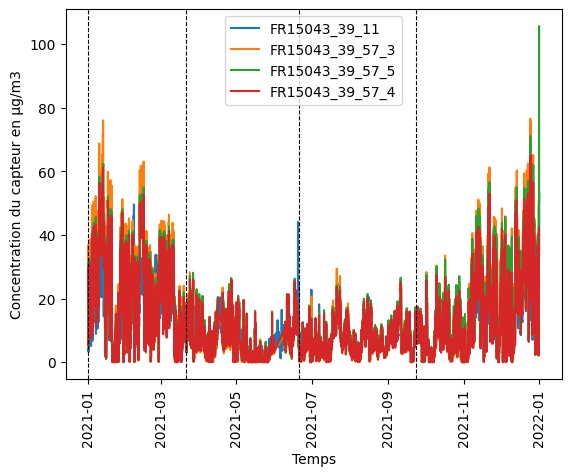

In [33]:
# data_1['date'] = pd.to_datetime(data_1['date'])
for mesure in data_2021['mesure_id'].unique():
    plt.plot(data_2021.loc[data_2021['mesure_id']==mesure]['date'],data_2021.loc[data_2021['mesure_id']==mesure]['valeur'],label=f'{mesure}')
winter_index = data_2021.index[data_2021['season'] == 'winter']
spring_index = data_2021.index[data_2021['season'] == 'spring']
summer_index = data_2021.index[data_2021['season'] == 'summer']
autumn_index = data_2021.index[data_2021['season'] == 'autumn']

seasons = ['winter', 'spring', 'summer', 'autumn']
for i, season in enumerate(seasons):
    next_season = seasons[(i + 1) % len(seasons)]
    
#     # Trouver la date de transition
    current_season_end = data_2021[data_2021['season'] == season]['date'].max()
    next_season_start = data_2021[data_2021['season'] == next_season]['date'].min()
    
    if (current_season_end is not None) and (next_season_start is not None):
        if current_season_end != next_season_start:
            plt.axvline(x=next_season_start, linestyle='--', color='black',linewidth=0.8)
plt.xlabel('Temps')
plt.ylabel('Concentration du capteur en µg/m3')
plt.xticks(rotation=90)
plt.legend()

* Visualiser les données horaire sur une période d'une année, on peut le faire aussi pour les saisons, pour voir l'impact de la saisonnalité sur les donnés.

In [34]:
data_2022 = data_2022.loc[data_2022['mesure_id'].isin([mesure_1,mesure_2,mesure_3,'FR15043_39_11'])]
data_2023 = data_2023.loc[data_2023['mesure_id'].isin([mesure_1,mesure_2,mesure_3,'FR15043_39_11'])]

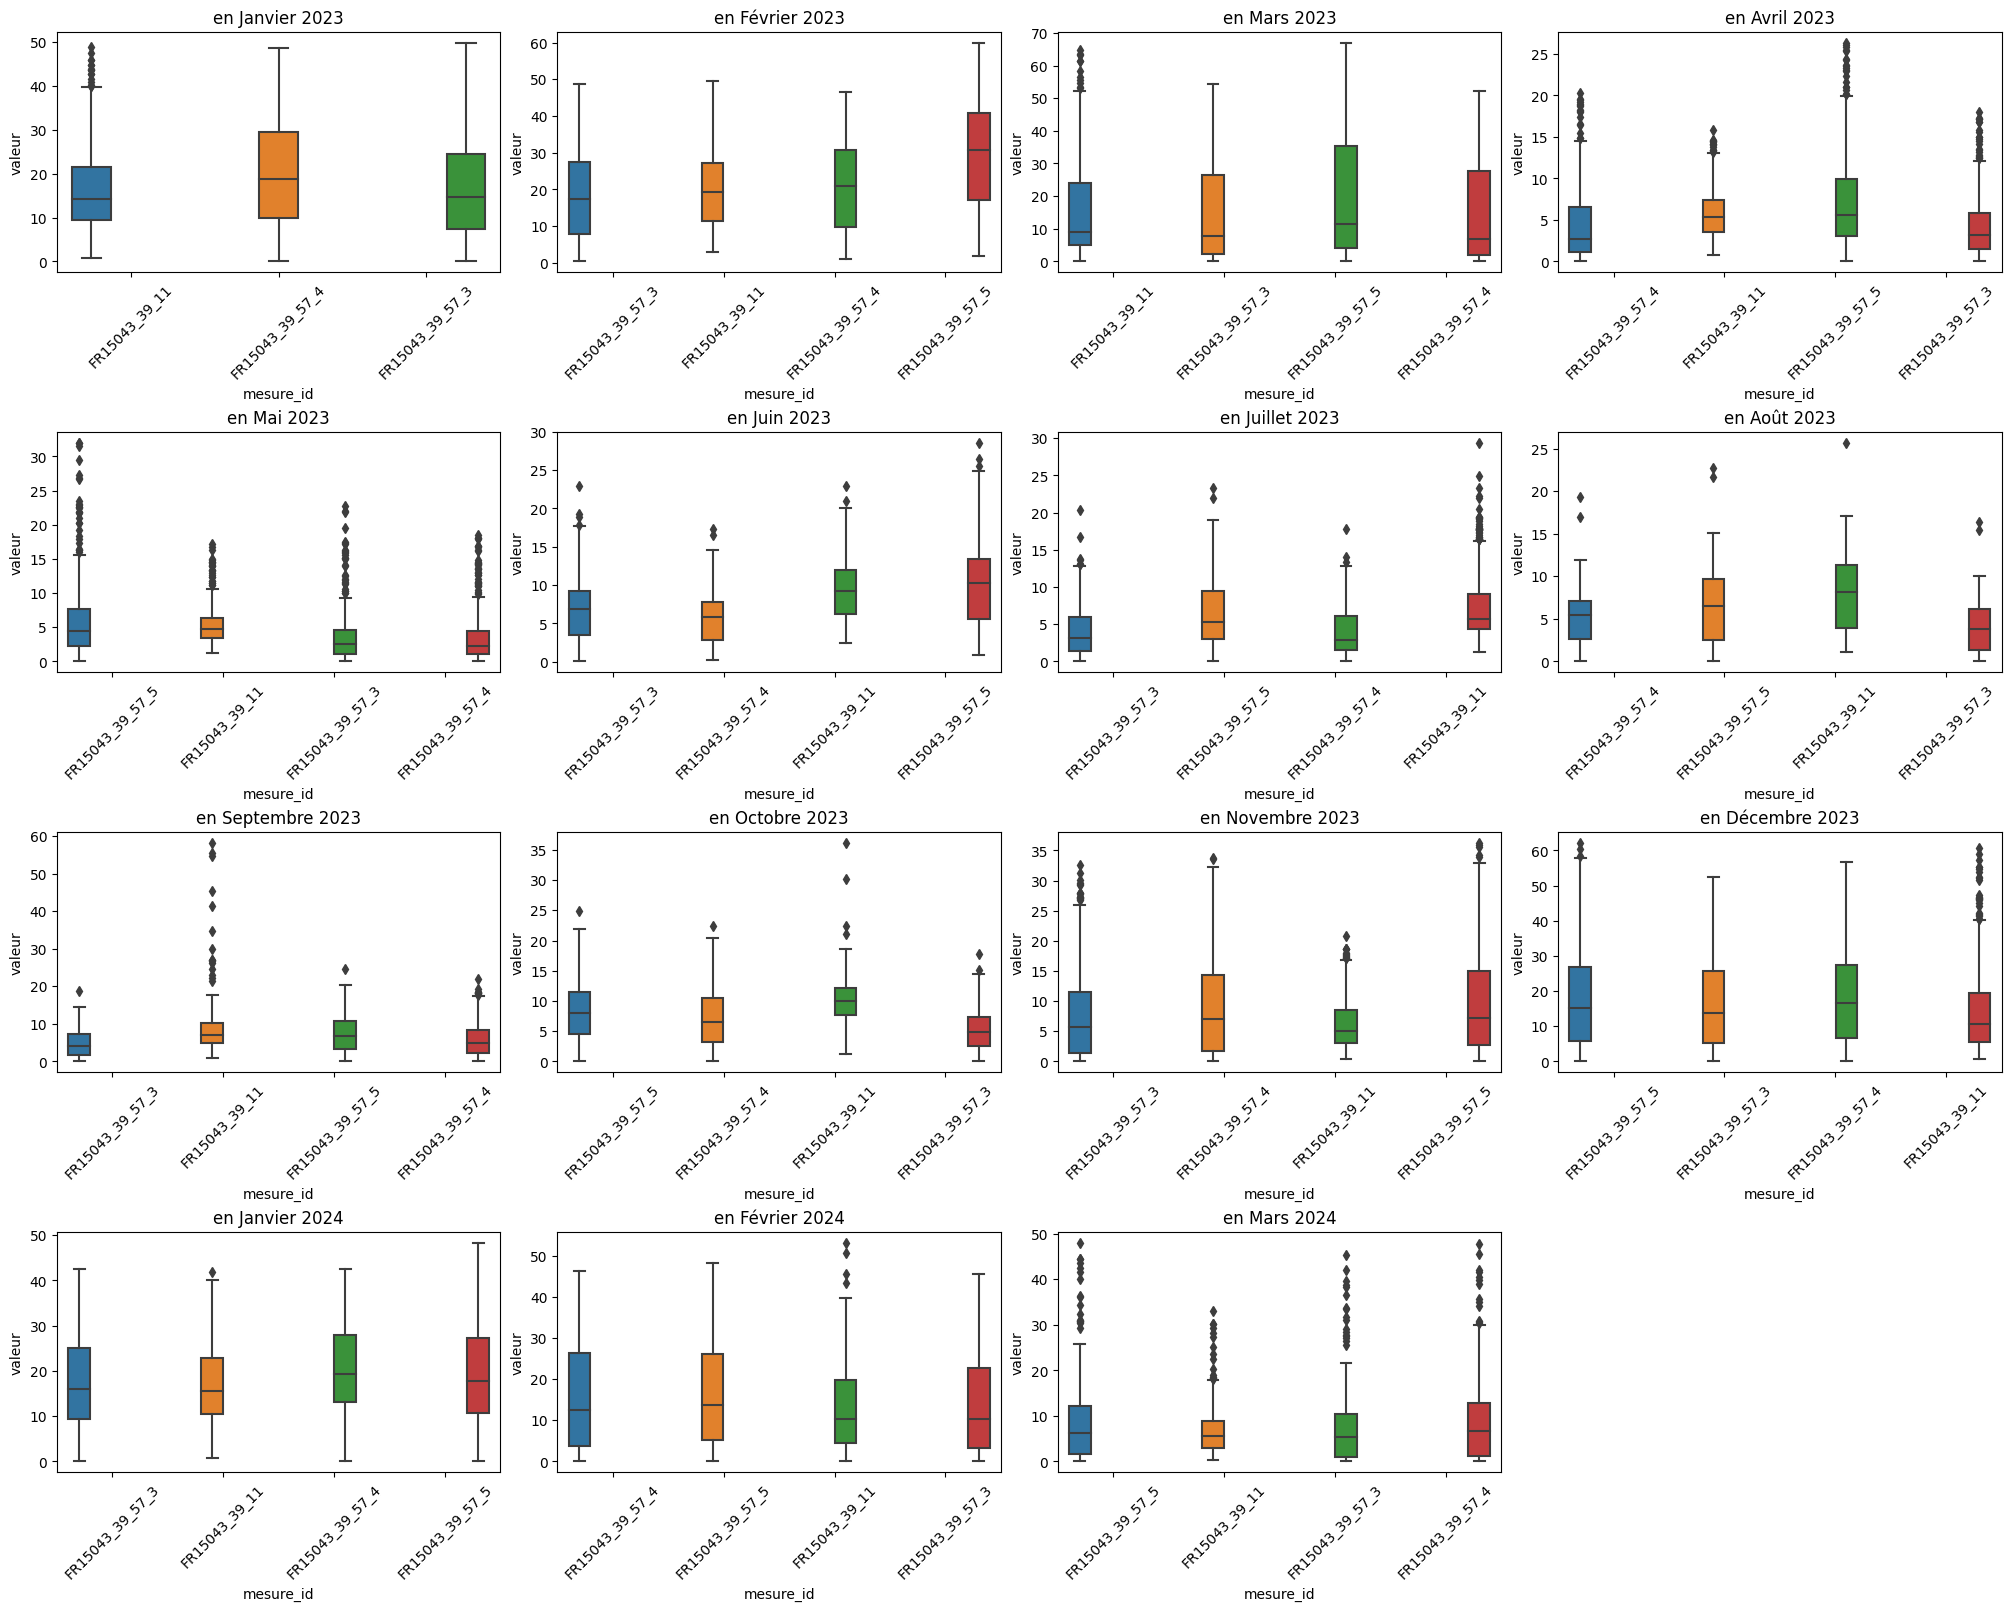

In [ ]:
# On peut voir aussi pour les autres années
monthly_data = [g for n, g in data_2023.set_index('date').groupby(pd.Grouper(freq='M'))] # une liste des dataFrame, chaque dataframe représente une fréquence donnée
num_months = len(monthly_data)
fig, axes = plt.subplots((num_months // 4) + 1, 4, figsize=(20, (num_months // 4 + 1) * 4), constrained_layout=True)
axes = axes.flatten()

for i, month in enumerate(monthly_data):
    if not month.empty:
        sns.boxplot(x='mesure_id', y='valeur', hue='mesure_id', data=month, ax=axes[i])
        month_name = format_date(month.index[0], format='MMMM yyyy', locale='fr_FR')
        axes[i].set_title(f'en {month_name.capitalize()}')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend().set_visible(False)  # Masquer la légende de chaque subplot pour éviter les doublons

# Supprimer les sous-graphiques vides si num_months < nombre total de sous-graphiques
for j in range(num_months, len(axes)):
    fig.delaxes(axes[j])

plt.show()

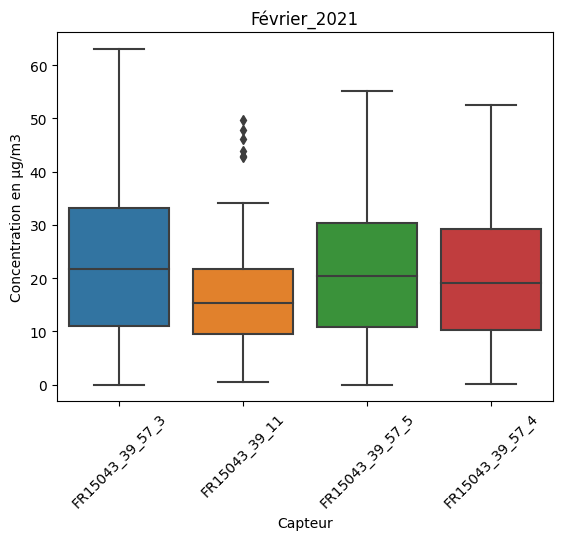

In [ ]:
# Voir la répartition des données par mois
import locale
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')
def boxplot(data,mois):
    data['month'] = data['date'].dt.month_name(locale='fr_FR')
    data['annee'] = data['date'].dt.year 
    data_month = data.loc[data['month']==mois]
    std = data
    sns.boxplot(x='mesure_id', y='valeur', data=data_month)
    year = data_month['annee'].unique()[0]
    plt.xlabel('Capteur')
    plt.ylabel('Concentration en µg/m3')
    plt.title(f'{mois}_{year}')
    plt.xticks(rotation=45)
    plt.show()
    # plt.legend()
# Exemple pour le mois de février
boxplot(data_2021,'Février')
    

In [ ]:
# Valeur moyenne horaire de concentration pour une période d'une seule année pour chaque capteur
def val_moy_heure(data):
    data['heure'] = data['date'].dt.hour
    dict = {'heure':[],'mesure_id':[],'valeur_horaire':[]}
    for heure in data['heure'].unique():
        for mesure in data['mesure_id'].unique():
            valeur_horaire = data.loc[(data['heure'] == heure) & (data['mesure_id'] == mesure), 'valeur'].mean()
            dict['heure'].append(heure)
            dict['mesure_id'].append(mesure)
            dict['valeur_horaire'].append(valeur_horaire)
    df_horaire = pd.DataFrame(data=dict)
    for mesure in df_horaire['mesure_id'].unique():
        plt.plot(df_horaire.loc[df_horaire['mesure_id']==mesure]['heure'],df_horaire.loc[df_horaire['mesure_id']==mesure]['valeur_horaire'],label=f'{mesure}')
    plt.xlabel('Temps')
    plt.ylabel('Concentration du capteur en µg/m3')
    plt.xticks(rotation=45)
    plt.legend()

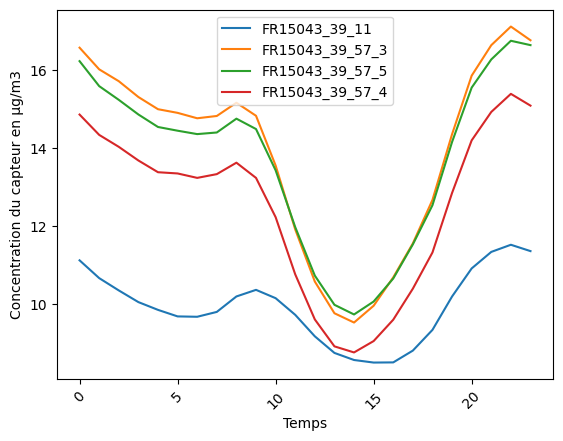

In [38]:
val_moy_heure(data_2021)

In [ ]:
# Valeur moyenne journalière pour une période d'une seule année de concentration pour chaque capteur
def val_moy_jour(data):
    data['jour'] = data['date'].dt.day_name()
    dict = {'jour':[],'mesure_id':[],'valeur_jour':[]}
    for jour in data['jour'].unique():
        for mesure in data['mesure_id'].unique():
            valeur_jour = data.loc[(data['jour'] == jour) & (data['mesure_id'] == mesure), 'valeur'].mean()
            dict['jour'].append(jour)
            dict['mesure_id'].append(mesure)
            dict['valeur_jour'].append(valeur_jour)
    df_jour = pd.DataFrame(data=dict)
    for mesure in df_jour['mesure_id'].unique():
        plt.plot(df_jour.loc[df_jour['mesure_id']==mesure]['jour'],df_jour.loc[df_jour['mesure_id']==mesure]['valeur_jour'],label=f'{mesure}')
    plt.xlabel('Temps')
    plt.ylabel('Concentration du capteur en µg/m3')
    plt.xticks(rotation=45)
    plt.legend()

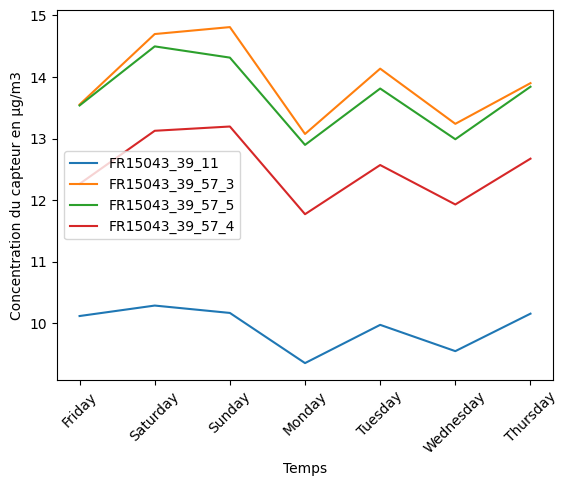

In [40]:
val_moy_jour(data_2021)

* Voir les statistiques des données, on peut aussi aller voir ces statistiques par mois ou par saison 

In [41]:
dict_stat = {'mesure_id':['FR15043_39_11',mesure_1,mesure_2,mesure_3],'moyenne':[],'écart_type':[],'CV %':[]}

moyenne_ref = data_complet_cap1['valeur_reference'].mean()
ecart_type_ref = data_complet_cap1['valeur_reference'].std()
dict_stat['écart_type'].append(ecart_type_ref)
dict_stat['moyenne'].append(moyenne_ref)
dict_stat['CV %'].append((ecart_type_ref/moyenne_ref)*100)

moyenne_1 = data_complet_cap1[f'valeur_{mesure_1}'].mean()
ecart_type_1 = data_complet_cap1[f'valeur_{mesure_1}'].std()
dict_stat['écart_type'].append(ecart_type_1)
dict_stat['moyenne'].append(moyenne_1)
dict_stat['CV %'].append((ecart_type_1/moyenne_1)*100)

moyenne_2 = data_complet_cap2[f'valeur_{mesure_2}'].mean()
ecart_type_2 = data_complet_cap2[f'valeur_{mesure_2}'].std()
dict_stat['écart_type'].append(ecart_type_2)
dict_stat['moyenne'].append(moyenne_2)
dict_stat['CV %'].append((ecart_type_2/moyenne_2)*100)


moyenne_3 = data_complet_cap3[f'valeur_{mesure_3}'].mean()
ecart_type_3 = data_complet_cap3[f'valeur_{mesure_3}'].std()
dict_stat['écart_type'].append(ecart_type_3)
dict_stat['moyenne'].append(moyenne_3)
dict_stat['CV %'].append((ecart_type_3/moyenne_3)*100)


df_stat = pd.DataFrame(data=dict_stat)
df_stat

,mesure_id,moyenne,écart_type,CV %
0,FR15043_39_11,10.888259,8.601857,79.001215
1,FR15043_39_57_3,11.794045,12.677043,107.486811
2,FR15043_39_57_4,11.716994,11.708146,99.924486
3,FR15043_39_57_5,12.965095,12.432781,95.894247


In [42]:
def stat(data,mois):
    data['annee'] = data['date'].dt.year 
    data['month'] = data['date'].dt.month_name(locale='fr_FR')
    data_month = data.loc[(data['month']==mois)]
    dict_stat = {'mesure_id':[],'moyenne':[],'écart_type':[],'CV %':[]}
    for mesure in data_month['mesure_id'].unique():
        moyenne = data_month.loc[data_month['mesure_id'] == mesure]['valeur'].mean()
        ecart_type = data_month.loc[data_month['mesure_id'] == mesure]['valeur'].std()
        dict_stat['écart_type'].append(ecart_type)
        dict_stat['mesure_id'].append(mesure)
        dict_stat['moyenne'].append(moyenne)
        dict_stat['CV %'].append((ecart_type/moyenne)*100)
    df_stat = pd.DataFrame(data=dict_stat)
    return df_stat
stat(data_2022,'Février')

,mesure_id,moyenne,écart_type,CV %
0,FR15043_39_11,10.251488,6.796510,66.297788
1,FR15043_39_57_3,11.500491,11.141596,96.879303
2,FR15043_39_57_5,12.965104,11.722887,90.418762
3,FR15043_39_57_4,10.788958,9.971314,92.421468


In [43]:
dict_stat = {'mesure_id':[],'moyenne':[],'écart_type':[],'CV %':[]}
for mesure in data_2022['mesure_id'].unique():
    moyenne = data_2022.loc[data_2022['mesure_id'] == mesure]['valeur'].mean()
    ecart_type = data_2022.loc[data_2022['mesure_id'] == mesure]['valeur'].std()
    dict_stat['écart_type'].append(ecart_type)
    dict_stat['mesure_id'].append(mesure)
    dict_stat['moyenne'].append(moyenne)
    dict_stat['CV %'].append((ecart_type/moyenne)*100)
df_stat = pd.DataFrame(data=dict_stat)
df_stat


,mesure_id,moyenne,écart_type,CV %
0,FR15043_39_57_5,12.692567,12.307714,96.967886
1,FR15043_39_11,11.460599,8.572497,74.799729
2,FR15043_39_57_4,11.311973,11.746767,103.843663
3,FR15043_39_57_3,11.363763,12.422767,109.319134


In [ ]:
r2_score(data_complet_cap1.loc[(data_complet_cap1['annee']==2021) & (data_complet_cap1['mois']=='January')][f'valeur_{mesure_1}'],data_complet_cap1.loc[(data_complet_cap1['annee']==2021) & (data_complet_cap1['mois']=='January')]['valeur_reference'])

In [ ]:
def r_2(data_complet,mesure):
    dict_stat2 = {'Mois_Année':[],'r': [],'MAE':[],'RMSE':[]}
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            # model = LinearRegression()
            Y = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)]['valeur_reference'].values.reshape(-1,1)
            X = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)][f'valeur_{mesure}'].values.reshape(-1,1)
            
            # model.fit()
            # print(data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)][['valeur_reference',f'valeur_{mesure}']])
            score = r2_score(data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)][f'valeur_{mesure}'],data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)]['valeur_reference'])
            dict_stat2['r'].append(score)
            dict_stat2['Mois_Année'].append(mois + ' (' + str(annee) + ')')
            dict_stat2['MAE'].append(mean_absolute_error(X,Y))
            dict_stat2['RMSE'].append(np.sqrt(mean_squared_error(X,Y)))
    stat2 = pd.DataFrame(data=dict_stat2)
    return stat2
            
r_2(data_complet_cap1,mesure_1)

In [ ]:
data_2022['date'] = pd.to_datetime(data_2022['date'])
merged = get_merged(data_2022)
dict_stat2 = {'mesure_id': [],'equation':[],'r2': [],'biais':[]}
Y = merged['valeur'].values.reshape(-1, 1)
for mesure in data_2022['mesure_id'].unique():
    model = LinearRegression()
    if mesure[-2:] == '11':
        continue
    X = merged[f'valeur_{mesure}'].values.reshape(-1, 1)
    Y_nonzero = np.where(Y == 0, np.finfo(float).eps, Y)  # Remplacer les zéros par une très petite valeur
    biais = np.mean((X - Y) / Y_nonzero)
    model.fit(X, Y)
    r2 = model.score(X,Y)
    equation = f'{model.coef_[0][0]:.2f}*x + {model.intercept_[0]:.2f}'
    dict_stat2['mesure_id'].append(mesure)
    dict_stat2['equation'].append(equation)
    dict_stat2['r2'].append(r2)
    dict_stat2['biais'].append(biais)
stat2 = pd.DataFrame(data=dict_stat2)
stat2

* Impact des valeurs mesurées sur la performance

In [ ]:
get_Rh(data_complet_cap1,mesure_1,row=4,column=4)

In [ ]:
# merged = get_merged(data)
# merged['date'] = pd.to_datetime(merged['date'])
# data_complet = pd.merge(merged,meteo_api,on='date',how='inner')
# data_complet_france = pd.merge(merged,climat,on='date',how='inner')
get_bias_Rh(data_complet_2021_cap1,mesure_1)

In [ ]:
plt.figure()
plt.hist(data_complet.loc[data_complet.index.month==6][f'valeur_reference'])

plt.figure()
plt.hist(data_complet.loc[data_complet.index.month==7][f'valeur_reference'])

plt.figure()
plt.hist(data_complet.loc[data_complet.index.month==6][f'valeur_temp'])

plt.figure()
plt.hist(data_complet.loc[data_complet.index.month==7][f'valeur_temp'])

plt.figure()
plt.hist(climat.loc[climat['date'].dt.month==6][f'U'])

plt.figure()
plt.hist(climat.loc[climat['date'].dt.month==7][f'U'])

In [ ]:
get_Rh(data_complet_1,mesure_1,row=4,column=4)

In [ ]:
from matplotlib import dates
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Plot of deg_C with time in the first week")

for i in range(15,22):
    
    
    one_day = data_complet[(data_complet.index >= "2021-02-" +str(i) +" 00:00:00") & 
                         (data_complet.index <= "2021-02-" +str(i) +" 23:00:00")]
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_reference",ax=ax)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H-%M'))
    ax.xaxis.set_major_locator(dates.HourLocator(interval=12))

plt.show()

In [ ]:
from matplotlib import dates
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Plot of deg_C with time in the first week")

for i in range(15,22):
    
    
    one_day = data_complet[(data_complet.index >= "2021-02-" +str(i) +" 00:00:00") & 
                         (data_complet.index <= "2021-02-" +str(i) +" 23:00:00")]
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_temp",ax=ax)
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_reference",ax=ax)
    sns.lineplot(data=one_day, x=one_day.index, y=f"valeur_{mesure_1}",ax=ax)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H-%M'))
    ax.xaxis.set_major_locator(dates.HourLocator(interval=12))

plt.show()

In [ ]:
from matplotlib import dates
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Plot of deg_C with time in the second week")

for i in range(22,29):
    
    
    one_day = data_complet[(data_complet_cap.index >= "2021-02-" +str(i) +" 00:00:00") & 
                         (data_complet.index <= "2021-02-" +str(i) +" 23:00:00")]
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_temp",ax=ax)
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_reference",ax=ax)
    sns.lineplot(data=one_day, x=one_day.index, y=f"valeur_{mesure_1}",ax=ax)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H-%M'))
    ax.xaxis.set_major_locator(dates.HourLocator(interval=6))

plt.show()

In [ ]:
from matplotlib import dates
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Plot of relative humidity with time in the first week")

for i in range(15,22):
    
    
    one_day = data_complet[(data_complet.index >= "2021-02-" +str(i) +" 00:00:00") & 
                         (data_complet.index <= "2021-02-" +str(i) +" 23:00:00")]
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_hum",ax=ax)
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_reference",ax=ax)
    sns.lineplot(data=one_day, x=one_day.index, y=f"valeur_{mesure_1}",ax=ax)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H-%M'))
    ax.xaxis.set_major_locator(dates.HourLocator(interval=12))

plt.show()

In [ ]:
dict_meteo = {'mois':[],'meteo_france':[],'capteur':[]}
for mois in climat['date'].dt.month.unique():
    dict_meteo['mois'].append(mois)
    dict_meteo['meteo_france'].append(climat.loc[climat['date'].dt.month==mois]['U'].mean())
    dict_meteo['capteur'].append(data_complet.loc[data_complet.index.month==mois]['valeur_hum'].mean())
data_meteo = pd.DataFrame(data=dict_meteo)
data_meteo

In [ ]:
from matplotlib import dates
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Plot of relative humidity with time in the second week")

for i in range(22,29):
    
    
    one_day = data_complet[(data_complet.index >= "2021-02-" +str(i) +" 00:00:00") & 
                         (data_complet.index <= "2021-02-" +str(i) +" 23:00:00")]
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_hum",ax=ax)
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_reference",ax=ax)
    sns.lineplot(data=one_day, x=one_day.index, y=f"valeur_{mesure_1}",ax=ax)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H-%M'))
    ax.xaxis.set_major_locator(dates.HourLocator(interval=12))

plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(data_complet['valeur_reference'],lags=360,ax=ax,title="monthly seasonality using ACF - reference")
fig.show()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = plot_acf(data_complet[f'valeur_{mesure_1}'],lags=360,ax=ax,title="monthly seasonality using ACF - micro_1")
fig.show()

# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(211)
# fig = plot_acf(data_complet[f'valeur_{mesure_2}'],lags=360,ax=ax,title="monthly seasonality using ACF - micro_2")
# fig.show()

# fig = plt.figure(figsize=(12,8))
# ax = fig.add_subplot(211)
# fig = plot_acf(data_complet[f'valeur_{mesure_3}'],lags=360,ax=ax,title="monthly seasonality using ACF - micro_3")
# fig.show()

In [ ]:
sns.pairplot(data_complet[['valeur_reference',f'valeur_{mesure_1}','valeur_hum','valeur_temp']])

* Introduire les données météorologiques

In [ ]:
get_multi_regression(data,meteo_api,mesure,freq='M')

In [ ]:
get_Rh(data_complet_1,mesure_1)

In [ ]:
df = get_metrics_per_week(data,seuil=0.0,freq='M')
df_w = get_metrics_per_week(data,seuil=0.01,freq='W')

In [ ]:
for mesure in df['mesure_id'].unique():
    plt.plot(df.loc[df['mesure_id']==mesure , 'semaine'],df.loc[df['mesure_id']==mesure , 'r2'],label=mesure)
# plt.axhline(y=0,c='r',ls='--',lw=1)
for i in range(1,len(list(df['semaine'].unique()))):
    if i%1==0:
        plt.axvline(x=i,linestyle='--')
plt.xlabel('Semaine')
plt.ylabel('r2')
plt.legend()

In [ ]:
data['month'] = data['date'].dt.month
data_juin = data.loc[(data['month']==6) & (data['season']=='spring')]
df_juin = get_metrics_per_week(data_juin,seuil=0.0,freq='W')
for mesure in df_juin['mesure_id'].unique():
    plt.plot(df_juin.loc[df_juin['mesure_id']==mesure , 'semaine'],df_juin.loc[df_juin['mesure_id']==mesure , 'r2'],label=mesure)
    # plt.axhline(y=df.loc[df['mesure_id']==mesure , 'MAE'].mean(),c='r',ls='--',lw=1,label=)
for i in range(1,len(list(df_juin['semaine'].unique()))+1):
    plt.axvline(x=i)
plt.xlabel('Semaine')
plt.ylabel('r2')
plt.legend()

In [ ]:
merged_juin = get_merged(data_juin)
second_week = [g for n, g in merged_juin.set_index('date').groupby(pd.Grouper(freq='W'))][1]
plt.plot(second_week['valeur'],label='reference')
plt.plot(second_week[f'valeur_{mesure_3}'],label=f'{mesure_1}')
plt.axhline(y=20)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
second_week[['valeur',f'valeur_{mesure_1}']].corr()

In [ ]:
second_week['heure'] = second_week.index.hour
dict = {}
heure = []
moy_valeur = []
moy_capteur = []
for hour in second_week['heure'].unique():
    heure.append(hour)
    data_heure = second_week.loc[second_week['heure']==hour]['valeur'].mean()
    data_heure_capteur = second_week.loc[second_week['heure']==hour][f'valeur_{mesure_1}'].mean()
    moy_valeur.append(data_heure)
    moy_capteur.append(data_heure_capteur)
dict['heure'] = heure
dict['ref'] = moy_valeur
dict[f'{mesure_1}'] = moy_capteur

df_heure = pd.DataFrame(data=dict)



In [ ]:
second_week['jour'] = second_week.index.day_name()
second_week

In [ ]:
plt.plot(df_heure['heure'],df_heure['ref'],label='reference')
plt.plot(df_heure['heure'],df_heure[f'{mesure_1}'],label=f'{mesure_1}')
for i in range(len(df_heure)):
    plt.axvline(x=i,linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
dict_j = {}
jour = []
moy_valeur_j = []
moy_capteur_j = []
for day in second_week['jour'].unique():
    jour.append(day)
    data_jour = second_week.loc[second_week['jour']==day]['valeur'].mean()
    data_jour_capteur = second_week.loc[second_week['jour']==day][f'valeur_{mesure_1}'].mean()
    moy_valeur_j.append(data_jour)
    moy_capteur_j.append(data_jour_capteur)
dict_j['jour'] = jour
dict_j['ref'] = moy_valeur_j
dict_j[f'{mesure_1}'] = moy_capteur_j

df_j = pd.DataFrame(data=dict_j)
df_j

In [ ]:
plt.plot(df_j['jour'],df_j['ref'],label='reference')
plt.plot(df_j['jour'],df_j[f'{mesure_1}'],label=f'{mesure_1}')
for i in range(len(df_j)):
    plt.axvline(x=i,linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
data_fevrier = data.loc[data['month']==2]
df_fevrier = get_metrics_per_week(data_fevrier,seuil=0.0,freq='W')
for mesure in df_fevrier['mesure_id'].unique():
    plt.plot(df_fevrier.loc[df_fevrier['mesure_id']==mesure , 'semaine'],df_fevrier.loc[df_fevrier['mesure_id']==mesure , 'r2'],label=mesure)
    # plt.axhline(y=df.loc[df['mesure_id']==mesure , 'MAE'].mean(),c='r',ls='--',lw=1,label=)
for i in range(1,len(list(df_fevrier['semaine'].unique()))):
    plt.axvline(x=i)
plt.xlabel('Semaine')
plt.ylabel('r2')
plt.legend()

In [ ]:
merged_fevrier = get_merged(data_fevrier)
plt.plot(merged_fevrier['date'],merged_fevrier['valeur'],label='reference')
plt.plot(merged_fevrier['date'],merged_fevrier[f'valeur_{mesure_1}'],label=f'{mesure_1}')
plt.axhline(y=20)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
fourth_week = [g for n, g in merged_fevrier.set_index('date').groupby(pd.Grouper(freq='W'))][3]
plt.plot(fourth_week['valeur'],label='reference')
plt.plot(fourth_week[f'valeur_{mesure_1}'],label=f'{mesure_1}')
plt.axhline(y=20)
plt.xticks(rotation=45)
plt.legend()
plt.show()
print((merged_fevrier[f'valeur_{mesure_2}']/merged_fevrier['valeur']).mean())

In [ ]:
fourth_week['heure'] = fourth_week.index.hour
dict_fev = {}
heure_fev = []
moy_valeur_fev = []
moy_capteur_fev = []
for hour in fourth_week['heure'].unique():
    heure_fev.append(hour)
    data_heure = fourth_week.loc[fourth_week['heure']==hour]['valeur'].mean()
    data_heure_capteur = fourth_week.loc[fourth_week['heure']==hour][f'valeur_{mesure_1}'].mean()
    moy_valeur_fev.append(data_heure)
    moy_capteur_fev.append(data_heure_capteur)
dict_fev['heure'] = heure_fev
dict_fev['ref'] = moy_valeur_fev
dict_fev[f'{mesure_1}'] = moy_capteur_fev

df_heure_fev = pd.DataFrame(data=dict_fev)

In [ ]:
fourth_week[['valeur',f'valeur_{mesure_1}']].corr()

In [ ]:
plt.plot(df_heure_fev['heure'],df_heure_fev['ref'],label='reference')
plt.plot(df_heure_fev['heure'],df_heure_fev[f'{mesure_1}'],label=f'{mesure_1}')
for i in range(len(df_heure_fev)):
    plt.axvline(x=i,linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
fourth_week['jour'] = fourth_week.index.day_name()
dict_j_fev = {}
jour_fev = []
moy_valeur_j_fev = []
moy_capteur_j_fev = []
for day in fourth_week['jour'].unique():
    jour_fev.append(day)
    data_jour = fourth_week.loc[fourth_week['jour']==day]['valeur'].mean()
    data_jour_capteur = fourth_week.loc[fourth_week['jour']==day][f'valeur_{mesure_1}'].mean()
    moy_valeur_j_fev.append(data_jour)
    moy_capteur_j_fev.append(data_jour_capteur)
dict_j_fev['jour'] = jour_fev
dict_j_fev['ref'] = moy_valeur_j_fev
dict_j_fev[f'{mesure_1}'] = moy_capteur_j_fev

df_j_fev = pd.DataFrame(data=dict_j_fev)
df_j_fev

In [ ]:
plt.plot(df_j_fev['jour'],df_j_fev['ref'],label='reference')
plt.plot(df_j_fev['jour'],df_j_fev[f'{mesure_1}'],label=f'{mesure_1}')
for i in range(len(df_j_fev)):
    plt.axvline(x=i,linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
fourth_week_weekend = fourth_week.loc[(fourth_week['jour']=='Saturday') | (fourth_week['jour']=='Sunday')]
plt.plot(fourth_week_weekend['valeur'],label='reference')
plt.plot(fourth_week_weekend[f'valeur_{mesure_1}'],label=f'{mesure_1}')
saturday_index = fourth_week_weekend.index[fourth_week_weekend['jour'] == 'Saturday']
sunday_index = fourth_week_weekend.index[fourth_week_weekend['jour'] == 'Sunday']
plt.axhline(y=20, linestyle='--', color='green')
# Ajouter une ligne verticale entre samedi et dimanche
for i in range(len(saturday_index)):
    saturday_day = saturday_index[i]
    next_day = saturday_day + pd.Timedelta(days=1)
    if next_day in sunday_index:
        plt.axvline(x=next_day, linestyle='--', color='red')
        break
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
df_calib = apply_calibration(data,mesure_2,seuil=0.0,freq='M')
df_calib.loc[df_calib['mesure_id']==f'{mesure_3}']['r2_après_calibration'].mean()

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Covariate drift for deg_C")
sns.kdeplot(data_complet_1['valeur_temp'].values, c='r',label='2022')
sns.kdeplot(data_complet['valeur_temp'].values, c='b',label='2021')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title("Covariate drift for relative_humidity")
sns.kdeplot(data_complet_1['valeur_hum'].values, c='r',label='2022')
sns.kdeplot(data_complet['valeur_hum'].values, c='b',label='2021')
plt.legend()
plt.show()


plt.figure(figsize=(12,8))
plt.title("Covariate drift for sensor")
sns.kdeplot(data_complet_1['valeur'].values, c='r',label='2022')
sns.kdeplot(data_complet['valeur'].values, c='b',label='2021')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title("Covariate drift for sensor_1")
sns.kdeplot(data_complet_1[f'valeur_{mesure_1}'].values, c='r',label='2022')
sns.kdeplot(data_complet[f'valeur_{mesure_1}'].values, c='b',label='2021')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title("Covariate drift for sensor_2")
sns.kdeplot(data_complet_1[f'valeur_{mesure_2}'].values, c='r',label='2022')
sns.kdeplot(data_complet[f'valeur_{mesure_2}'].values, c='b',label='2021')
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.title("Covariate drift for sensor_3")
sns.kdeplot(data_complet_1[f'valeur_{mesure_3}'].values, c='r',label='2022')
sns.kdeplot(data_complet[f'valeur_{mesure_3}'].values, c='b',label='2021')
plt.legend()
plt.show()

## Modèles de calibrations

* Entrainement des modèles

In [ ]:
nbr_val = len(data_2021.loc[data_2021['mesure_id']==mesure_3]) + len(data_2022.loc[data_2022['mesure_id']==mesure_3]) + len(data_2023.loc[data_2023['mesure_id']==mesure_3])
nbr = len(data_complet_cap3)
taux = (nbr/nbr_val)*100
taux


In [ ]:
def get_correlations(data_complet,mesure):
    correlations = {'Mois_Année':[],'Corr_temp':[],'Corr_hum':[],'Corr_reference_temp':[],'Corr_reference_hum':[],'ind_hum':[],'ind_temp':[]}
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            corr = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)][['valeur_temp','valeur_hum',f'valeur_{mesure}','valeur_reference']].corr()
            correlations['Mois_Année'].append(mois + '_' + str(annee))
            correlations['Corr_temp'].append(corr.iloc[0,-2])
            correlations['Corr_hum'].append(corr.iloc[1,-2])
            correlations['Corr_reference_temp'].append(corr.iloc[0,-1])
            correlations['Corr_reference_hum'].append(corr.iloc[1,-1])
            correlations['ind_hum'].append(abs(corr.iloc[1,-1]/corr.iloc[1,-2]))
            correlations['ind_temp'].append(abs(corr.iloc[0,-1]/corr.iloc[0,-2]))
    corre = pd.DataFrame(data=correlations)
    fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(12, 16))

    # sns.barplot(data=corre, x='Mois_Année', y='Corr_temp', color='red', edgecolor='gray', ax=ax1, label='Corr_temp')
    sns.barplot(data=corre, x='Mois_Année', y='Corr_hum', color='blue', edgecolor='gray', ax=ax1, label='Corr_hum', alpha=0.7)
    # sns.barplot(data=corre, x='Mois_Année', y='Corr_reference_temp', color='green', edgecolor='gray', ax=ax1, label='Corr_reference_temp', alpha=0.7)
    sns.barplot(data=corre, x='Mois_Année', y='Corr_reference_hum', color='yellow', edgecolor='gray', ax=ax1, label='Corr_reference_hum', alpha=0.7)
    ax1.set_title(f'Correlation par mois pour {mesure}', fontsize=16)
    ax1.set_xlabel('Mois', fontsize=14)
    ax1.set_ylabel('Correlation', fontsize=14)
    ax1.tick_params(axis='x', labelsize=10, rotation=90)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.axhline(y=-0.4, color='gray', linestyle='--')
    ax1.axhline(y=0.4, color='gray', linestyle='--')
    ax1.axhline(y=0., color='gray', linestyle='--')
    ax1.axvline(x=10.5, color='gray', linestyle='--')
    ax1.axvline(x=22.5, color='gray', linestyle='--')
    ax1.axvline(x=34.5, color='gray', linestyle='--')
    # handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(fontsize=12, title_fontsize='13', loc='lower left')
    
    # sns.barplot(data=corre, x='Mois_Année', y='Corr_temp', color='red', edgecolor='gray', ax=ax1, label='Corr_temp')
    sns.barplot(data=corre, x='Mois_Année', y='Corr_temp', color='blue',  ax=ax2, label='Corr_temp', alpha=0.7)
    # sns.barplot(data=corre, x='Mois_Année', y='Corr_reference_temp', color='green', edgecolor='gray', ax=ax1, label='Corr_reference_temp', alpha=0.7)
    sns.barplot(data=corre, x='Mois_Année', y='Corr_reference_temp', color='red', ax=ax2, label='Corr_reference_temp', alpha=0.7)
    ax2.set_title(f'Correlation par mois pour {mesure}', fontsize=16)
    ax2.set_xlabel('Mois', fontsize=14)
    ax2.set_ylabel('Correlation', fontsize=14)
    ax2.tick_params(axis='x', labelsize=10, rotation=90)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.axhline(y=-0.4, color='gray', linestyle='--')
    ax2.axhline(y=0.4, color='gray', linestyle='--')
    ax2.axhline(y=0., color='gray', linestyle='--')
    ax2.axvline(x=10.5, color='gray', linestyle='--')
    ax2.axvline(x=22.5, color='gray', linestyle='--')
    ax2.axvline(x=34.5, color='gray', linestyle='--')
    # handles, labels = ax2.get_legend_handles_labels()
    ax2.legend( fontsize=12, title_fontsize='13', loc='lower left')

    plt.tight_layout()
    plt.show()
    return corre

In [ ]:
get_correlations(data_complet_cap1,mesure_1)

In [ ]:
from matplotlib import dates
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Plot of deg_C with time in the second week")

for i in range(22,29):
    
    
    one_day = data_complet_cap1[(data_complet_cap1.index >= "2021-2-" +str(i) +" 00:00:00") & 
                         (data_complet_cap1.index <= "2021-2-" +str(i) +" 23:00:00")]
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_temp",ax=ax,label="valeur_temp")
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_hum",ax=ax,label="valeur_hum")
    sns.lineplot(data=one_day, x=one_day.index, y="valeur_reference",ax=ax,label="valeur_reference")
    sns.lineplot(data=one_day, x=one_day.index, y=f"valeur_{mesure_1}",ax=ax,label=f"valeur_{mesure_1}")
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H-%M'))
    ax.xaxis.set_major_locator(dates.HourLocator(interval=6))

plt.show()

In [ ]:
def corr_week(data_complet,mesure,annee,mois):
    correlations = {'Mois_Année':[],'Corr_temp':[],'Corr_hum':[],'Corr_reference_temp':[],'Corr_reference_hum':[],'ref_cap':[],'Corr_hum_diff':[],'Corr_temp_diff':[]}
    data_complet = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)]
    weeks = [g for n, g in data_complet.groupby(pd.Grouper(freq='W'))]
    
    for week in weeks:
        corr = week[['valeur_temp','valeur_hum',f'valeur_{mesure}','valeur_reference']].corr()
        correlations['Mois_Année'].append(mois + '_' + str(annee))
        correlations['Corr_temp'].append(corr.iloc[0,-2])
        correlations['Corr_hum'].append(corr.iloc[1,-2])
        correlations['Corr_reference_temp'].append(corr.iloc[0,-1])
        correlations['Corr_reference_hum'].append(corr.iloc[1,-1])
        correlations['Corr_hum_diff'].append(corr.iloc[1,-2]-corr.iloc[1,-1])
        correlations['Corr_temp_diff'].append(corr.iloc[0,-2]-corr.iloc[0,-1])
        correlations['ref_cap'].append(corr.iloc[2,-1])
        
    corre = pd.DataFrame(data=correlations)
    return corre
    

In [ ]:
def corr_month(data_complet,mesure):
    correlations = {'Mois_Année':[],'Corr_temp':[],'Corr_hum':[],'Corr_reference_temp':[],'Corr_reference_hum':[],'ref_cap':[],'Corr_hum_diff':[],'Corr_temp_diff':[]}
    # data_complet = data_complet.loc[(data_complet['annee']==annee)]
    weeks = [g for n, g in data_complet.groupby(pd.Grouper(freq='M'))]
    
    for week in weeks:
        corr = week[['valeur_temp','valeur_hum',f'valeur_{mesure}','valeur_reference']].corr()
        correlations['Mois_Année'].append(week['mois'].unique() + '_' + str(week['annee'].unique()))
        correlations['Corr_temp'].append(corr.iloc[0,-2])
        correlations['Corr_hum'].append(corr.iloc[1,-2])
        correlations['Corr_reference_temp'].append(corr.iloc[0,-1])
        correlations['Corr_reference_hum'].append(corr.iloc[1,-1])
        correlations['Corr_hum_diff'].append(corr.iloc[1,-2]-corr.iloc[1,-1])
        correlations['Corr_temp_diff'].append(corr.iloc[0,-2]-corr.iloc[0,-1])
     
        correlations['ref_cap'].append(corr.iloc[2,-1])
        
    corre = pd.DataFrame(data=correlations)
    corre = corre.dropna()
    return corre

In [ ]:
corr_month_1 = corr_month(data_complet_cap1,mesure_1)
corr_month_2 = corr_month(data_complet_cap2,mesure_2)
# corr_month_4 = corr_month(data_complet_cap,mesure)

In [ ]:
corr_month_1

In [ ]:
corr_month_3 = corr_month(data_complet_cap3,mesure_3)

In [ ]:
corr_week(data_complet_cap1,mesure_1,2022,'October')

In [ ]:
def mean_std_month(data_complet,mesure):
    ind = {'Mois_Année':[],'mean':[],'std':[],'mean_ref':[],'std_ref':[],'CV':[],'CV_ref':[]}
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            mean = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois) & (data_complet_cap1['jour'].isin(['Saturday','Sunday']))][f'valeur_{mesure}'].mean()
            std = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois) & (data_complet_cap1['jour'].isin(['Saturday','Sunday']))][f'valeur_{mesure}'].std()
            mean_ref = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois) & (data_complet_cap1['jour'].isin(['Saturday','Sunday']))]['valeur_reference'].mean()
            std_ref = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois) & (data_complet_cap1['jour'].isin(['Saturday','Sunday']))]['valeur_reference'].std()
            ind['Mois_Année'].append(mois + '_' + str(annee))
            ind['mean'].append(mean)
            ind['std'].append(std)
            ind['CV'].append(std/mean)
            ind['mean_ref'].append(mean_ref)
            ind['std_ref'].append(std_ref)
            ind['CV_ref'].append(std_ref/mean_ref)
        
    corre = pd.DataFrame(data=ind)
    return corre

In [ ]:
mean_std_month(data_complet_cap1,mesure_1)

In [ ]:
def Anomalie_spatiale(data_complet,mesure,mois,annee):
    ind = {'Mois_Année':[],'Anomalie_spatiale':[]}
    data_complet = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)]
    weeks = [g for n, g in data_complet.groupby(pd.Grouper(freq='D'))]
    
    k = 0
    while k < len(weeks):
        if len(weeks[k]) == 0:
            weeks.pop(k)
        else:
            k +=1
            
    for i in range (len(weeks)):
 
        Q1 = np.percentile(weeks[i]['valeur_reference'], 25)
        Q3 = np.percentile(weeks[i]['valeur_reference'], 75)
        IQR = Q3 - Q1
        minimum = Q1 - 1.5*IQR
        maximum = Q3 + 1.5*IQR
        for hour in weeks[i].index.hour.unique():
            valeur_horaire = weeks[i].loc[weeks[i].index.hour == hour][f'valeur_{mesure}'].values[0]
            ind['Mois_Année'].append(mois + '_jour_' + str(i+1) + '_heure_' + str(hour))
            ind['Anomalie_spatiale'].append((valeur_horaire > maximum) or (valeur_horaire < minimum))
    corre = pd.DataFrame(data=ind)
    return corre

In [ ]:
def anomalie_temporelle(data_complet,mesure,mois,annee):
    ind = {'Mois_Année':[],'diff':[],'Anomalie_temporelle':[]}
    data_complet = data_complet.loc[(data_complet['annee']==annee) & (data_complet['mois']==mois)]
    weeks = [g for n, g in data_complet.groupby(pd.Grouper(freq='D'))]
    for i in range (len(weeks)):
        for hour in weeks[i].index.hour.unique():
            valeur_horaire_1 = weeks[i].loc[weeks[i].index.hour == hour][f'valeur_{mesure}'].mean()
            valeur_horaire_0 = weeks[i].loc[weeks[i].index.hour == hour - 1][f'valeur_{mesure}'].mean()
            ind['Mois_Année'].append(mois + '_jour_' + str(i+1) + '_heure_' + str(hour) + '-' + str(hour - 1))
            ind['diff'].append(valeur_horaire_1 - valeur_horaire_0)
            ind['Anomalie_temporelle'].append(abs(valeur_horaire_1 - valeur_horaire_0)>3)
    corre = pd.DataFrame(data=ind)
    return corre

In [ ]:
X_data = data_complet_cap2[['valeur_temp','valeur_hum',f'valeur_{mesure_2}']]
X_data_1 = data_complet_cap2[[f'valeur_{mesure_2}']]
y_data = data_complet_cap2[['valeur_reference']]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,random_state=0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_data_1, y_data, test_size=0.2,random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import learning_curve 
from sklearn.model_selection import validation_curve 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

In [ ]:
def evaluation(model,X_train,y_train,cv):
    N,train_score,val_score = learning_curve(model,X_train,y_train,cv=cv,scoring='r2',train_sizes=np.linspace(0.1,1,10))
    plt.figure(figsize=(12,8))
    plt.plot(N,train_score.mean(axis=1),label='train_score')
    plt.plot(N,val_score.mean(axis=1),label='val_score')
    plt.legend()

In [ ]:
def test_best_model(best_model,data_complet,mesure):
    dict = {'Année':[],'mois':[],'score':[]}
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            data_mois = data_complet.loc[data_complet['mois']==mois]
            data_mois_X = data_mois[['valeur_temp','valeur_hum',f'valeur_{mesure}']]
            data_mois_y = data_mois[['valeur_reference']]
            pred_mois = best_model.predict(data_mois_X)
            dict['Année'].append(annee)
            dict['mois'].append(mois)
            dict['score'].append(r2_score(pred_mois,data_mois_y))
    df = pd.DataFrame(data=dict)
    return(df)

In [ ]:
def plot_and_evaluate(y_test, y_pred, time_index):
    # Calculate the error
    # y_pred = y_pred.reshape(-1,1)[0]
    y_pred = pd.Series(y_pred,index=time_index)
    y_pred = pd.DataFrame(data=y_pred)
    y_pred.rename(columns={0:'valeur'},inplace=True)
    error = y_test['valeur_reference'] - y_pred['valeur']
    # print(error.isna().sum())

    # Convert error to a pandas Series
    # error_series = pd.Series(error, index=time_index)


    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    # True vs Predicted values
    axs[0].scatter(y_test, y_pred)
    axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
    axs[0].set_xlabel('Valeur de référence')
    axs[0].set_ylabel('Valeurs prédites')
    axs[0].set_title('Référence vs Ajustement')

    # Error as a function of time
    axs[1].scatter(error.index,error)
    axs[1].axhline(y=0, color='k', linestyle='--')
    axs[1].set_xlabel('Temps')
    axs[1].set_ylabel('Erreur  (Ref - Pred)')
    axs[1].set_title('Erreur en fonction du temps')
    plt.tight_layout()
    plt.show()

* Preprocessing

* 1. Preprocessing pour randomForest , SVM , Adaboost 

In [ ]:
cv=KFold(5,random_state=0,shuffle=True)
# cv=ShuffleSplit(5,test_size=0.2)
# cv = StratifiedKFold(5)
months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

In [ ]:
Randomforest = RandomForestRegressor(random_state=0,bootstrap=True)
Adaboost = AdaBoostRegressor(random_state=0)
Catboost = CatBoostRegressor(random_state=0)
gradboost = GradientBoostingRegressor(random_state=0)

* Les modèles de calibration (de correction)

In [ ]:
def apply_model_non_linear(model,X_train,X_test,y_train,y_test, valid = True):
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude=np.number)
    print(categorical_features)

    numerical_pipeline = make_pipeline(RobustScaler())
    categorical_pipeline = make_pipeline(OrdinalEncoder(categories=[months,days]))

    preprocessor = make_column_transformer((numerical_pipeline,numerical_features),(categorical_pipeline,categorical_features),remainder='passthrough')
    model_pipeline = make_pipeline(preprocessor,model)
    param_grid = {
        'randomforestregressor__n_estimators': [100, 200, 500],
        'randomforestregressor__max_depth': [None, 10, 20, 30],
        'randomforestregressor__min_samples_split': [2, 5, 10]
    }
    grid_forest = GridSearchCV(model_pipeline,param_grid,cv=cv,scoring='r2')
    grid_forest.fit(X_train,y_train)

    # Meilleur modèle
    meilleur_model = grid_forest.best_estimator_
    pred = meilleur_model.predict(X_test)
    r2_score_test = r2_score(pred,y_test)
    rmse_test = np.sqrt(mean_squared_error(pred,y_test))
    if valid :
        plot_and_evaluate(y_test, pred, y_test.index)
    return meilleur_model,r2_score_test,rmse_test
    

* 2. Preprocessing pour une régressionn linéaire

Utilisation de SGDregressor en prenant en compte plusieurs paramètes avec le rajout des variables polynomiales

In [ ]:
def Lasso_model(X_train,y_train,X_test,y_test,valid=True):
    numerical_features = make_column_selector(dtype_include=np.number)
    numerical_pipeline = make_pipeline(RobustScaler(),PolynomialFeatures())
    linear_preprocessor = make_column_transformer((numerical_pipeline,numerical_features))
    model = make_pipeline(linear_preprocessor,Lasso(random_state=0))
    param_grid = {
    'columntransformer__pipeline__polynomialfeatures__degree': [2, 3, 4],
    'lasso__alpha': np.logspace(-4, -1, 200),
    'lasso__max_iter': [100, 1000]
    }
    grid = GridSearchCV(model,param_grid,cv=5,scoring='r2')
    grid.fit(X_train,y_train)
    print("Best parameters found: ", grid.best_params_)
    # Meilleur modèle
    meilleur_model = grid.best_estimator_
    pred = meilleur_model.predict(X_test)
    r2_score_test = r2_score(pred,y_test)
    rmse_test = np.sqrt(mean_squared_error(pred,y_test))
    if valid:
        plot_and_evaluate(y_test,pred,y_test.index)
    return meilleur_model,r2_score_test,rmse_test

In [ ]:
def Ridge_model(X_train,y_train,X_test,y_test,valid=True):
    numerical_features = make_column_selector(dtype_include=np.number)
    numerical_pipeline = make_pipeline(RobustScaler(),PolynomialFeatures())
    linear_preprocessor = make_column_transformer((numerical_pipeline,numerical_features))
    model = make_pipeline(linear_preprocessor,Ridge(random_state=0))
    param_grid = {
    'columntransformer__pipeline__polynomialfeatures__degree': [2, 3, 4],
    'ridge__alpha': np.logspace(-4, -1, 200),
    'ridge__max_iter': [100, 1000]
    }
    grid = GridSearchCV(model,param_grid,cv=5,scoring='r2')
    grid.fit(X_train,y_train)
    print("Best parameters found: ", grid.best_params_)
    # Meilleur modèle
    meilleur_model = grid.best_estimator_
    pred = meilleur_model.predict(X_test)
    r2_score_test = r2_score(pred,y_test)
    rmse_test = np.sqrt(mean_squared_error(pred,y_test))
    pred = pred.reshape(1,-1)[0]
    if valid:
        plot_and_evaluate(y_test,pred,y_test.index)
    return meilleur_model,r2_score_test,rmse_test

Utilisation d' une régression polynomiale simple 

In [ ]:
def model_polynomial(X_train,y_train,X_test,y_test,valid=True):
    numerical_features = make_column_selector(dtype_include=np.number)
    numerical_pipeline = make_pipeline(RobustScaler(),PolynomialFeatures())
    linear_preprocessor = make_column_transformer((numerical_pipeline,numerical_features))
    model_1 = make_pipeline(linear_preprocessor,LinearRegression())
    param_grid_1 = {
    'columntransformer__pipeline__polynomialfeatures__degree' : [2,3,4,5,6,7,8],
    }
    grid_1 = GridSearchCV(model_1,param_grid_1,cv=cv,scoring='r2')
    grid_1.fit(X_train,y_train)
    print("Best parameters found: ", grid_1.best_params_)
    # Meilleur modèle
    meilleur_model = grid_1.best_estimator_
    pred = meilleur_model.predict(X_test)
    r2_score_test = r2_score(pred,y_test)
    rmse_test = np.sqrt(mean_squared_error(pred,y_test))
    pred = pred.reshape(1,-1)[0]
    if valid:
        plot_and_evaluate(y_test,pred,y_test.index)
    return meilleur_model,r2_score_test,rmse_test

Régression simple

In [ ]:
def multi_linear_regression(X_train,y_train,X_test,y_test,valid=True):
    numerical_features = make_column_selector(dtype_include=np.number)
    numerical_pipeline = make_pipeline(RobustScaler())
    linear_preprocessor = make_column_transformer((numerical_pipeline,numerical_features))
    model_2 = make_pipeline(linear_preprocessor,LinearRegression())
    grid = GridSearchCV(model_2,{},cv=cv,scoring='r2')
    grid.fit(X_train,y_train)
    # Meilleur modèle
    meilleur_model = grid.best_estimator_
    pred = meilleur_model.predict(X_test)
    r2_score_test = r2_score(pred,y_test)
    rmse_test = np.sqrt(mean_squared_error(pred,y_test))
    pred = pred.reshape(1,-1)[0]
    if valid:
        plot_and_evaluate(y_test,pred,y_test.index)
    return meilleur_model,r2_score_test,rmse_test

In [ ]:
def svr(X_train,y_train,X_test,y_test,valid=True):
    numerical_features = make_column_selector(dtype_include=np.number)
    numerical_pipeline = make_pipeline(StandardScaler())
    linear_preprocessor = make_column_transformer((numerical_pipeline,numerical_features))
    model_2 = make_pipeline(linear_preprocessor,SVR(kernel='linear',epsilon=0.05))
    param_grid = {
    'svr__kernel' : ['rbf','poly','sigmoid'],
    }
    grid_2 = GridSearchCV(model_2,param_grid,cv=cv,scoring='r2')
    grid_2.fit(X_train,y_train)
    # Meilleur modèle
    meilleur_model = grid_2.best_estimator_
    # print(meilleur_model)
    pred = meilleur_model.predict(X_test)
    r2_score_test = r2_score(pred,y_test)
    rmse_test = np.sqrt(mean_squared_error(pred,y_test))
    pred = pred.reshape(1,-1)[0]
    if valid:
        plot_and_evaluate(y_test,pred,y_test.index)
    return meilleur_model,r2_score_test,rmse_test

In [ ]:
def linear_regression(X_train,y_train,X_test,y_test,valid=True):
    numerical_features = make_column_selector(dtype_include=np.number)
    numerical_pipeline = make_pipeline(RobustScaler())
    linear_preprocessor = make_column_transformer((numerical_pipeline,numerical_features))
    model_2 = make_pipeline(linear_preprocessor,LinearRegression())
    grid_2 = GridSearchCV(model_2,{},cv=5,scoring='r2')
    grid_2.fit(X_train,y_train)
    # Meilleur modèle
    meilleur_model = grid_2.best_estimator_
    pred = meilleur_model.predict(X_test)
    r2_score_test = r2_score(pred,y_test)
    rmse_test = np.sqrt(mean_squared_error(pred,y_test))
    pred = pred.reshape(1,-1)[0]
    if valid:
        plot_and_evaluate(y_test,pred,y_test.index)
    return meilleur_model,r2_score_test,rmse_test

In [ ]:
evaluation(Randomforest,X_train,y_train,5)

In [ ]:
models = {'Randomforest':Randomforest}
linear_models = {'RLM':multi_linear_regression,'R_polynomial':model_polynomial}

* Entrainer chaque mois tout seul

In [ ]:
def select_mois(data_complet,mesure,mois,annee):
#     if (mois not in list(data_complet['mois'].unique())):
#         print('veuillez entrer le bon mois')
    data_mois = data_complet.loc[(data_complet['mois']==mois) & (data_complet['annee']==annee)]
    data_mois_X = data_mois[['valeur_hum','valeur_temp',f'valeur_{mesure}']]
    data_mois_y = data_mois[['valeur_reference']]
    if len(data_mois_X) > 0 and len(data_mois_y) > 0:
            X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_mois_X, data_mois_y, test_size=0.2,random_state=0)
    else:
        print(f"No data available for annee: {annee}, mois: {mois}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    return X_train_mois, X_test_mois, y_train_mois, y_test_mois

In [ ]:
def select_mois_1(data_complet,mesure,mois,annee):
    #     if (mois not in list(data_complet['mois'].unique())):
#         print('veuillez entrer le bon mois')
    data_mois = data_complet.loc[(data_complet['mois']==mois) & (data_complet['annee']==annee)]
    data_mois_X = data_mois[[f'valeur_{mesure}']]
    data_mois_y = data_mois[['valeur_reference']]
    if len(data_mois_X) > 0 and len(data_mois_y) > 0:
            X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_mois_X, data_mois_y, test_size=0.2,random_state=0)
    else:
        print(f"No data available for annee: {annee}, mois: {mois}")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    return X_train_mois, X_test_mois, y_train_mois, y_test_mois

* Corriger les capteurs chaque mois

In [ ]:
def linear_model_scores_1(data_complet,mesure):
    dict_score_1 = {'Mois_Année':[],'score':[],'RMSE':[]}
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            X_train_mois, X_test_mois, y_train_mois, y_test_mois = select_mois_1(data_complet,mesure,mois,annee)
            meilleur_model,r2,rmse = linear_regression(X_train_mois,y_train_mois,X_test_mois,y_test_mois,valid=False)
            dict_score_1['Mois_Année'].append(mois + ' (' + str(annee) + ')')
            dict_score_1['score'].append(r2)
            dict_score_1['RMSE'].append(rmse)
    data_score_1 = pd.DataFrame(data=dict_score_1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    # Premier graphe pour le score
    sns.barplot(data=data_score_1, x='Mois_Année', y='score', palette='coolwarm', edgecolor='gray', ax=ax1)
    ax1.set_title(f'Score pour le capteur {mesure}', fontsize=16)
    ax1.set_xlabel('Mois', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.tick_params(axis='x', labelsize=12, rotation=45)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.legend( fontsize=12, title_fontsize='13', loc='lower left')

    # Deuxième graphe pour le RMSE
    sns.barplot(data=data_score_1, x='Mois_Année', y='RMSE', palette='coolwarm', edgecolor='gray', ax=ax2)
    ax2.set_title(f'RMSE pour le capteur {mesure}', fontsize=16)
    ax2.axhline(y=4,c='gray',linestyle='--')
    ax2.set_xlabel('Mois', fontsize=14)
    ax2.set_ylabel('RMSE', fontsize=14)
    ax2.tick_params(axis='x', labelsize=12, rotation=45)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.legend( fontsize=12, title_fontsize='13', loc='lower left')
    # Affichez les graphiques
    plt.tight_layout()
    plt.show()
    return data_score_1

In [ ]:
# modele non linéaire et linéaire pour 2021 et 2022
def linear_model_scores(data_complet,mesure):
    dict_score_1 = {'Mois_Année':[],'score':[],'RMSE':[],'Model':[]}
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            for model in list(linear_models.keys()):
                X_train_mois, X_test_mois, y_train_mois, y_test_mois = select_mois(data_complet,mesure,mois,annee)
                meilleur_model,r2,rmse = linear_models[model](X_train_mois,y_train_mois,X_test_mois,y_test_mois,valid=True)
                dict_score_1['Mois_Année'].append(mois + ' (' + str(annee) + ')')
                dict_score_1['Model'].append(model)
                dict_score_1['score'].append(r2)
                dict_score_1['RMSE'].append(rmse)
    data_score_1 = pd.DataFrame(data=dict_score_1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    # Premier graphe pour le score
    sns.barplot(data=data_score_1, x='Mois_Année', y='score',hue='Model', palette='coolwarm', edgecolor='gray', ax=ax1)
    ax1.set_title(f'Score pour le capteur {mesure}', fontsize=16)
    ax1.set_xlabel('Mois', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.tick_params(axis='x', labelsize=12, rotation=45)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')

    # Deuxième graphe pour le RMSE
    sns.barplot(data=data_score_1, x='Mois_Année', y='RMSE', hue='Model', palette='coolwarm', edgecolor='gray', ax=ax2)
    ax2.set_title(f'RMSE pour le capteur {mesure}', fontsize=16)
    ax2.axhline(y=4,c='gray',linestyle='--')
    ax2.set_xlabel('Mois', fontsize=14)
    ax2.set_ylabel('RMSE', fontsize=14)
    ax2.tick_params(axis='x', labelsize=12, rotation=45)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')
    # Affichez les graphiques
    plt.tight_layout()
    plt.show()
    return data_score_1

In [ ]:
def scores(data_complet,mesure):   
    dict_score = {'Mois_Année':[],'Model':[],'score':[],'RMSE':[]}
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            for model in list(models.keys()):
                X_train_mois, X_test_mois, y_train_mois, y_test_mois = select_mois(data_complet,mesure,mois,annee)
                meilleur_model,r2,rmse = apply_model_non_linear(models[model],X_train_mois, X_test_mois, y_train_mois, y_test_mois,valid=True)
                # r2,rmse = Ridge_model(X_train_mois,y_train_mois,X_test_mois,y_test_mois)
                # dict_score['Année'].append(annee)
                dict_score['Mois_Année'].append(mois + '_' + str(annee))
                dict_score['Model'].append(model)
                dict_score['score'].append(r2)
                dict_score['RMSE'].append(rmse)
    data_score = pd.DataFrame(data=dict_score)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    # Premier graphe pour le score
    sns.barplot(data=data_score, x='Mois_Année', y='score', hue='Model', palette='coolwarm', edgecolor='gray', ax=ax1)
    ax1.set_title(f'Score pour le capteur {mesure}', fontsize=16)
    ax1.set_xlabel('Mois', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.tick_params(axis='x', labelsize=12, rotation=45)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')

    # Deuxième graphe pour le RMSE
    sns.barplot(data=data_score, x='Mois_Année', y='RMSE', hue='Model', palette='coolwarm', edgecolor='gray', ax=ax2)
    ax2.set_title(f'RMSE pour le capteur {mesure}', fontsize=16)
    ax2.axhline(y=4,c='gray',linestyle='--')
    ax2.set_xlabel('Mois', fontsize=14)
    ax2.set_ylabel('RMSE', fontsize=14)
    ax2.tick_params(axis='x', labelsize=12, rotation=45)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')
    # Affichez les graphiques
    plt.tight_layout()
    plt.show()
    return data_score

In [ ]:
X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_complet_cap1[[f'valeur_{mesure_1}']],data_complet_cap1[['valeur_reference']] , test_size=0.2,random_state=0)
meilleur_model,r2,rmse = linear_regression(X_train_mois, y_train_mois, X_test_mois, y_test_mois,valid=True)

In [ ]:
X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_complet_cap2[[f'valeur_{mesure_2}']],data_complet_cap2[['valeur_reference']] , test_size=0.2,random_state=0)
meilleur_model,r2,rmse = linear_regression(X_train_mois, y_train_mois, X_test_mois, y_test_mois,valid=True)

In [ ]:
X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_complet_cap3[[f'valeur_{mesure_3}']],data_complet_cap3[['valeur_reference']] , test_size=0.2,random_state=0)
meilleur_model,r2,rmse = linear_regression(X_train_mois, y_train_mois, X_test_mois, y_test_mois,valid=True)

In [ ]:
linear_model_scores(data_complet_cap1,mesure_1)

In [ ]:
X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_complet_cap1[['valeur_hum','valeur_temp',f'valeur_{mesure_1}']],data_complet_cap1[['valeur_reference']] , test_size=0.2,random_state=0)
meilleur_model,r2,rmse = multi_linear_regression(X_train_mois, y_train_mois, X_test_mois, y_test_mois,valid=True)

In [ ]:
X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_complet_cap2[['valeur_hum','valeur_temp',f'valeur_{mesure_2}']],data_complet_cap2[['valeur_reference']] , test_size=0.2,random_state=0)
meilleur_model,r2,rmse = multi_linear_regression(X_train_mois, y_train_mois, X_test_mois, y_test_mois,valid=True)

In [ ]:
X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_complet_cap3[['valeur_hum','valeur_temp',f'valeur_{mesure_3}']],data_complet_cap3[['valeur_reference']] , test_size=0.2,random_state=0)
meilleur_model,r2,rmse = multi_linear_regression(X_train_mois, y_train_mois, X_test_mois, y_test_mois,valid=True)

In [ ]:
X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_complet_cap1[['valeur_hum','valeur_temp',f'valeur_{mesure_1}']],data_complet_cap1[['valeur_reference']] , test_size=0.2,random_state=0)
meilleur_model,r2,rmse = apply_model_non_linear(gradboost,X_train_mois, X_test_mois, y_train_mois, y_test_mois,valid=True)

In [160]:
X_train_mois, X_test_mois, y_train_mois, y_test_mois = train_test_split(data_complet_cap2[['valeur_hum','valeur_temp',f'valeur_{mesure_2}']],data_complet_cap2[['valeur_reference']] , test_size=0.2,random_state=0)
meilleur_model,r2,rmse = apply_model_non_linear(Randomforest,X_train_mois, X_test_mois, y_train_mois, y_test_mois,valid=True)

C:\Users\zarro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\zarro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\zarro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

KeyboardInterrupt: 

In [ ]:
print(r2)
print(meilleur_model)

In [ ]:
non_score_4 = scores(data_complet_cap,mesure_c1)

In [ ]:
non_scores_1 = scores(data_complet_cap1,mesure_1)
non_scores_2 = scores(data_complet_cap2,mesure_2)
non_scores_3 = scores(data_complet_cap3,mesure_3)

In [ ]:
non_scores_1 = scores(data_complet_cap1,mesure_1)

In [ ]:
month_mapping = {
    "January": "Janv",
    "February": "Fév",
    "March": "Mars",
    "April": "Avr",
    "May": "Mai",
    "June": "Juin",
    "July": "Juil",
    "August": "Août",
    "September": "Sept",
    "October": "Octob",
    "November": "Nov",
    "December": "Déc"
}
# Remplacer les mois en anglais par ceux en français
non_scores_1['Mois_Année'] = non_scores_1['Mois_Année'].replace({eng: fr for eng, fr in month_mapping.items()}, regex=True)
non_scores_2['Mois_Année'] = non_scores_2['Mois_Année'].replace({eng: fr for eng, fr in month_mapping.items()}, regex=True)
non_scores_3['Mois_Année'] = non_scores_3['Mois_Année'].replace({eng: fr for eng, fr in month_mapping.items()}, regex=True)
non_score_4['Mois_Année'] = non_score_4['Mois_Année'].replace({eng: fr for eng, fr in month_mapping.items()}, regex=True)

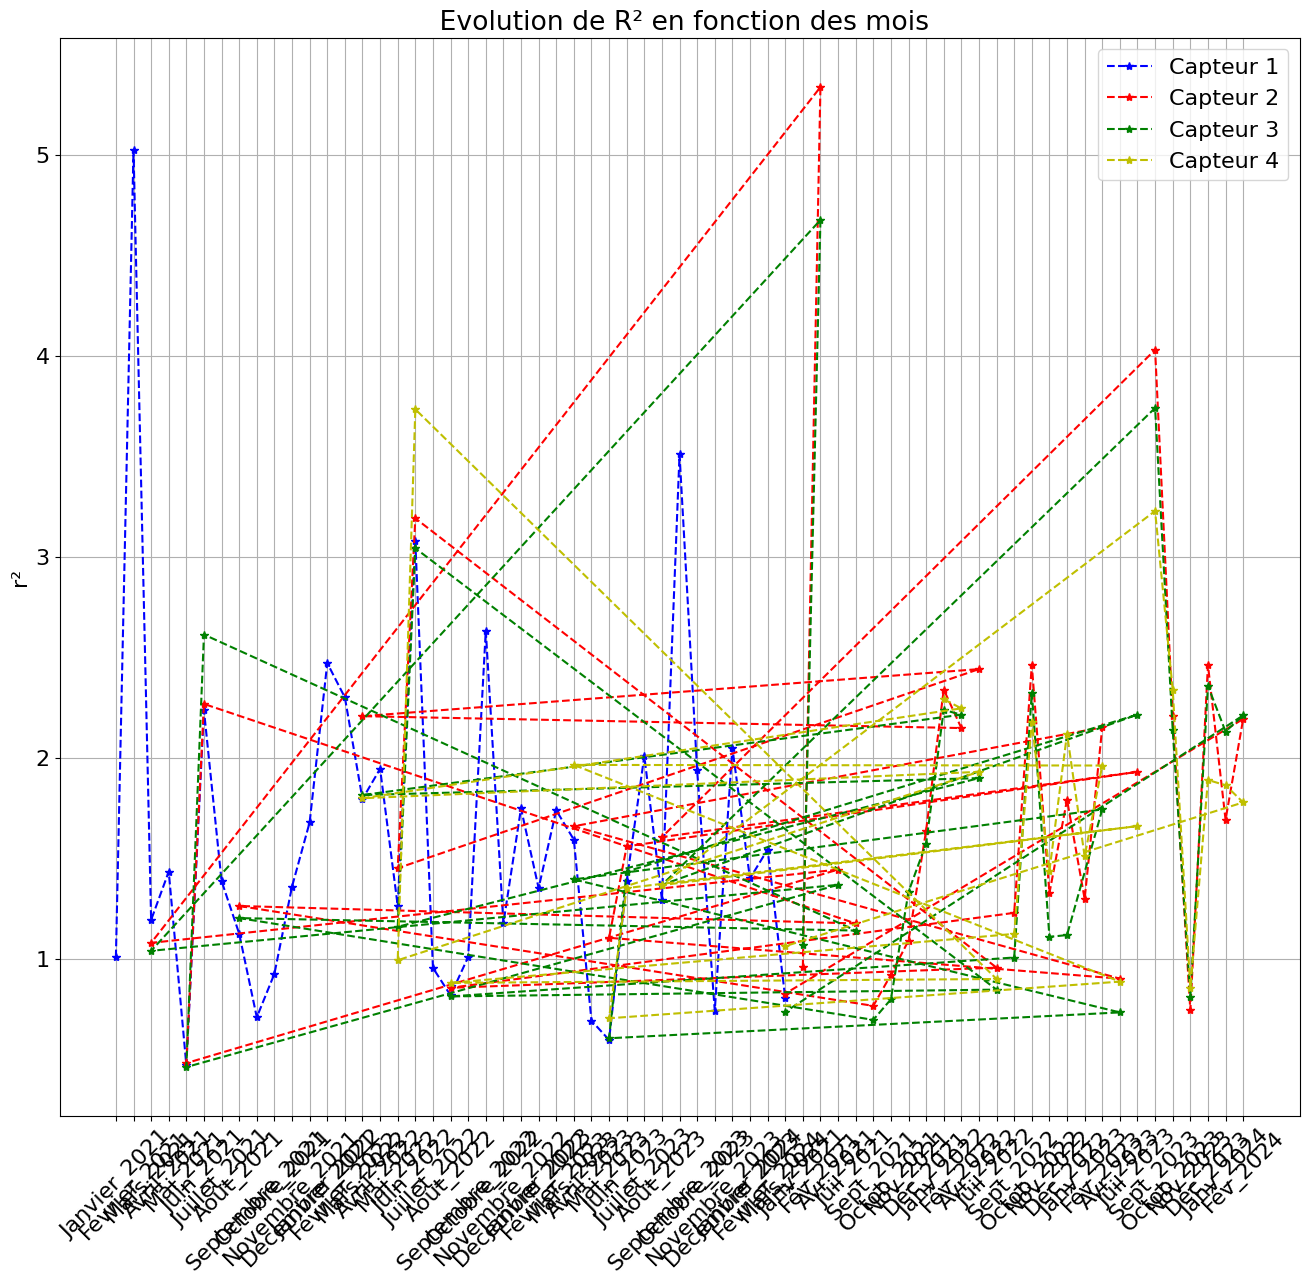

In [161]:

plt.figure(figsize=(16,14))
plt.plot(non_scores_1.loc[non_scores_1['Model']=='Randomforest']['Mois_Année'],non_scores_1.loc[non_scores_1['Model']=='Randomforest']['RMSE'],'b--*',label='Capteur 1')
plt.plot(non_scores_2.loc[non_scores_2['Model']=='Randomforest']['Mois_Année'],non_scores_2.loc[non_scores_2['Model']=='Randomforest']['RMSE'],'r--*',label='Capteur 2')
plt.plot(non_scores_3.loc[non_scores_3['Model']=='Randomforest']['Mois_Année'],non_scores_3.loc[non_scores_3['Model']=='Randomforest']['RMSE'],'g--*',label='Capteur 3')
plt.plot(non_score_4.loc[non_score_4['Model']=='Randomforest']['Mois_Année'],non_score_4.loc[non_score_4['Model']=='Randomforest']['RMSE'],'y--*',label='Capteur 4')
plt.legend()
plt.ylabel('r²')
plt.title(' Evolution de R² en fonction des mois')
plt.xticks(rotation=45)
plt.rcParams.update({'font.size': 16})
plt.markersize = 10
plt.linewidth = 2
plt.grid()

In [ ]:
def anomalies_detection(data_complet,mesure,mois,annee,model):
    dict_anomalie = {'Année_Mois':[],'Anomalie_spatiale':[]}
    dict_scores = {'Année_Mois':[],'r2':[],'RMSE':[]}
    # for annee in data_complet_cap1['annee'].unique():
    #     for mois in data_complet_cap1.loc[data_complet_cap1['annee']==annee]['mois'].unique():
    X_train_mois, X_test_mois, y_train_mois, y_test_mois = select_mois(data_complet,mesure,mois,annee)
    meilleur_model,r2,rmse = apply_model_non_linear(model,X_train_mois,X_test_mois,y_train_mois,y_test_mois,valid=False)
    dict_scores['Année_Mois'].append(mois + '_' + str(annee))
    dict_scores['r2'].append(r2)
    dict_scores['RMSE'].append(rmse)
                                       
    pol_pred = meilleur_model.predict(data_complet_cap1.loc[(data_complet_cap1['annee']==annee) & (data_complet_cap1['mois']==mois)][['valeur_hum','valeur_temp',f'valeur_{mesure_1}']])
    pol_ref = data_complet_cap1.loc[(data_complet_cap1['annee']==annee) & (data_complet_cap1['mois']==mois)][['valeur_reference']]
        
    pol_pred = pol_pred.reshape(1,-1)[0]
    pol_pred = pd.Series(pol_pred,index=pol_ref.index)
    pol_pred = pd.DataFrame(data=pol_pred)
    pol_pred.rename(columns={0:'valeur'},inplace=True)
        
    merge = pd.merge(pol_ref,pol_pred,how='inner',on=pol_ref.index)
    merge.rename(columns={'key_0':'date'},inplace=True)
    merge.set_index('date',inplace=True)
        
    weeks = [g for n, g in merge.groupby(pd.Grouper(freq='D'))]
    
    k = 0
    while k < len(weeks):
        if len(weeks[k]) == 0:
            weeks.pop(k)
        else:
            k +=1
            
    for i in range (len(weeks)):
 
        Q1 = np.percentile(weeks[i]['valeur_reference'], 25)
        Q3 = np.percentile(weeks[i]['valeur_reference'], 75)
        IQR = Q3 - Q1
        minimum = Q1 - 1.5*IQR
        maximum = Q3 + 1.5*IQR
        for hour in weeks[i].index.hour.unique():
            valeur_horaire = weeks[i].loc[weeks[i].index.hour == hour]['valeur'].values[0]
            dict_anomalie['Année_Mois'].append(mois + '_' + str(annee) + '_jour_' + str(i+1) + '_heure_' + str(hour))
            dict_anomalie['Anomalie_spatiale'].append((valeur_horaire > maximum) or (valeur_horaire < minimum))
    anomalies = pd.DataFrame(data=dict_anomalie)
    scores = pd.DataFrame(data=dict_scores)
    return anomalies, scores


In [ ]:
dict_anomalie_spatiale = {'Année_Mois':[],'taux_spatial':[],'r2':[],'rmse':[]}
for annee in data_complet_cap1['annee'].unique():
    for mois in data_complet_cap1.loc[data_complet_cap1['annee']==annee]['mois'].unique():
        anomalie_spatiale,scores = anomalies_detection(data_complet_cap1,mesure_1,mois,annee,Randomforest)
        taux_spatial = len(anomalie_spatiale.loc[anomalie_spatiale['Anomalie_spatiale']==True])/len(anomalie_spatiale)
#         # anomalie_temp = anomalie_temporelle(data_complet_cap1,mesure_1,mois,annee)
#         # taux_temporel = len(anomalie_temp.loc[anomalie_temp['Anomalie_temporelle']==True])/len(anomalie_temp)
        dict_anomalie_spatiale['Année_Mois'].append(mois + '_' + str(annee))
        dict_anomalie_spatiale['taux_spatial'].append(taux_spatial)
        dict_anomalie_spatiale['r2'].append(scores['r2'][0])
        dict_anomalie_spatiale['rmse'].append(scores['RMSE'][0])
        
#         dict_anomalie_spatiale['taux_temporel'].append(taux_temporel)
anomalies = pd.DataFrame(data=dict_anomalie_spatiale)

plt.figure(figsize=(16, 10))

# Plotter chaque série de données avec des couleurs différentes
plt.bar(anomalies["Année_Mois"], anomalies["taux_spatial"], color='skyblue', label='taux_spatial')
plt.bar(anomalies["Année_Mois"], anomalies["r2"], color='lightgreen', label='r2', alpha=0.7)
# plt.bar(anomalies["Année_Mois"], anomalies["rmse"], color='salmon', label='rmse', alpha=0.5)

# Rotation des labels de l'axe des x pour les rendre lisibles
plt.xticks(rotation=90)
plt.axhline(y=0.05)
plt.xlabel("Mois_Année")
plt.ylabel("Valeurs")
plt.title("Barplot des Taux Spatial, r2 et RMSE par Mois et Année")

# Ajouter une légende pour distinguer les différentes séries
plt.legend()
plt.grid()
plt.tight_layout()

# Afficher le plot
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))  # Ajuste la taille de la figure si nécessaire
sns.regplot(x=anomalies["taux_spatial"],
             y=anomalies["r2"],
             label='Score',ci=80)
plt.grid(True)
plt.legend()
plt.title('Score en fonction de Anomalie')
plt.xlabel('Anomalie')
plt.ylabel('Score')
plt.show()

# Création du deuxième graphique avec sns.lineplot
plt.figure(figsize=(10, 6))  # Ajuste la taille de la figure si nécessaire
sns.regplot(x=anomalies["taux_spatial"],
             y=anomalies["rmse"],scatter=False,
             label='RMSE', color='r',ci=80)
plt.grid(True)
plt.legend()
plt.title('RMSE en fonction de Anomalie')
plt.xlabel('Anomalie')
plt.ylabel('RMSE')
plt.show()

In [ ]:
corr_month_1 = corr_month_1[['Mois_Année','Corr_hum_diff']]

In [ ]:
courbe_1 = pd.merge(non_scores_1,corr_month_1,on='Mois_Année',how='inner')
courbe_1 = courbe_1.sort_values(by='Corr_hum_diff', ascending=True)

In [ ]:
(courbe_1['Corr_hum_diff'].max() - courbe_1['Corr_hum_diff'].min())/7

In [ ]:
intervalle_1 = courbe_1.loc[courbe_1['Corr_hum_diff']<0.05]
intervalle_2 = courbe_1.loc[(0.05 <=courbe_1['Corr_hum_diff']) & (courbe_1['Corr_hum_diff']< 0.084)]
intervalle_3 = courbe_1.loc[(0.084 <=courbe_1['Corr_hum_diff']) & (courbe_1['Corr_hum_diff']< 0.15)]
intervalle_4 = courbe_1.loc[(0.15 <=courbe_1['Corr_hum_diff']) & (courbe_1['Corr_hum_diff']< 0.2)]
intervalle_5 = courbe_1.loc[(0.2 <=courbe_1['Corr_hum_diff']) & (courbe_1['Corr_hum_diff']< 0.26)]
intervalle_6 = courbe_1.loc[(0.25 <=courbe_1['Corr_hum_diff']) & (courbe_1['Corr_hum_diff']<0.43)]


In [ ]:
metric = {'r_2':[], 'rmse':[], 'corr':[],'std':[]}

r1 = intervalle_1['score'].mean()
rmse1 = intervalle_1['RMSE'].mean()
corr1 = intervalle_1['score'].std()
std1 = intervalle_1['Corr_hum_diff'].mean()
metric['rmse'].append(rmse1)
metric['r_2'].append(r1)
metric['corr'].append(corr1)
metric['std'].append(std1)

r2 = intervalle_2['score'].mean()
rmse2 = intervalle_2['RMSE'].mean()
corr2 = intervalle_2['score'].std()
std2 = intervalle_2['Corr_hum_diff'].mean()
metric['rmse'].append(rmse2)
metric['r_2'].append(r2)
metric['corr'].append(corr2)
metric['std'].append(std2)

r3 = intervalle_3['score'].mean()
rmse3 = intervalle_3['RMSE'].mean()
corr3 = intervalle_3['score'].std()
std3 = intervalle_3['Corr_hum_diff'].mean()
metric['rmse'].append(rmse3)
metric['r_2'].append(r3)
metric['corr'].append(corr3)
metric['std'].append(std3)

r4 = intervalle_4['score'].mean()
rmse4 = intervalle_4['RMSE'].mean()
corr4 = intervalle_4['score'].std()
std4 = intervalle_4['Corr_hum_diff'].mean()
metric['rmse'].append(rmse4)
metric['r_2'].append(r4)
metric['corr'].append(corr4)
metric['std'].append(std4)

r5 = intervalle_5['score'].mean()
rmse5 = intervalle_5['RMSE'].mean()
corr5 = intervalle_5['score'].std()
std5 = intervalle_5['Corr_hum_diff'].mean()
metric['rmse'].append(rmse5)
metric['r_2'].append(r5)
metric['corr'].append(corr5)
metric['std'].append(std5)

r6 = intervalle_6['score'].mean()
rmse6 = intervalle_6['RMSE'].mean()
corr6 = intervalle_6['score'].std()
std6 = intervalle_6['Corr_hum_diff'].mean()
metric['rmse'].append(rmse6)
metric['r_2'].append(r6)
metric['corr'].append(corr6)
metric['std'].append(std6)

metrics = pd.DataFrame(data=metric)
metrics


In [ ]:
plt.errorbar(metrics['corr'], metrics['r_2'], metrics['std'], fmt='-o')

In [ ]:
plt.figure(figsize=(10, 6))  # Ajuste la taille de la figure si nécessaire
sns.regplot(x=corr_month_1['Corr_hum_diff'],
             y=non_scores_1.loc[non_scores_1['Model'] == 'Randomforest', 'score'],scatter=False,
             label='Capteur 1',ci=80)
sns.regplot(x=corr_month_2['Corr_hum_diff'],
             y=non_scores_2.loc[non_scores_1['Model'] == 'Randomforest', 'score'],scatter=False,
             label='Capteur 2',ci=80)
sns.regplot(x=corr_month_3['Corr_hum_diff'],
             y=non_scores_3.loc[non_scores_1['Model'] == 'Randomforest', 'score'],scatter=False,
             label='Capteur 3',ci=80)
plt.grid(True)
plt.legend()
plt.title('r² en fonction de la corrélation')
plt.xlabel('Corr_capteur_hum - Corr_référence_hum')
plt.ylabel('Score')
plt.show()

# Création du deuxième graphique avec sns.lineplot
plt.figure(figsize=(10, 6))  # Ajuste la taille de la figure si nécessaire
sns.regplot(x=corr_month_1['Corr_hum_diff'],
             y=non_scores_1.loc[non_scores_1['Model'] == 'Randomforest', 'RMSE'],scatter=False,
             label='Capteur 1', color='r',ci=80)
sns.regplot(x=corr_month_2['Corr_hum_diff'],
             y=non_scores_2.loc[non_scores_2['Model'] == 'Randomforest', 'RMSE'],scatter=False,
             label='Capteur 2', color='b',ci=80)
sns.regplot(x=corr_month_3['Corr_hum_diff'],
             y=non_scores_3.loc[non_scores_2['Model'] == 'Randomforest', 'RMSE'],scatter=False,
             label='Capteur 3', color='g',ci=80)
plt.grid(True)
plt.legend()
plt.title('RMSE en fonction de la corrélation')
plt.xlabel('Corr_capteur_hum - Corr_référence_hum')
plt.ylabel('RMSE')
plt.show()

Entrainer un mois et tester sur le prochain


In [ ]:
def train_month_linear(data_complet,mesure,freq='M'):
    score = {'Mois_Année_entrainé':[],'Mois_Année_test':[],'Model':[],'score':[],'RMSE':[]}
    months = [g for n, g in data_complet.groupby(pd.Grouper(freq=freq))]
    k = 0
    while k < len(months):
        if len(months[k]) == 0:
            months.pop(k)
        else:
            k +=1    
    for i in range(len(months)-1):
        mois_X_train = months[i][['valeur_hum','valeur_temp',f'valeur_{mesure}']]
        mois_y_train = months[i][['valeur_reference']]
        mois_X_test_1 = months[i+1][['valeur_hum','valeur_temp',f'valeur_{mesure}']]
        mois_y_test_1 = months[i+1][['valeur_reference']]
        # mois_X_test_2 = months[i+2][['valeur_hum','valeur_temp',f'valeur_{mesure_3}']]
        # mois_y_test_2 = months[i+2][['valeur_reference']]
        # for model in list(linear_models.keys()):
        for model in list(models.keys()):
            # meilleur_model,r2,rmse = linear_models[model](mois_X_train, mois_y_train ,mois_X_test_1, mois_y_test_1,valid=False)
            meilleur_model,r2,rmse = apply_model_non_linear(models[model],mois_X_train, mois_X_test_1, mois_y_train, mois_y_test_1)
            mois_annee_entrainé = '_'.join(months[i]['mois'].unique().astype(str)) + '_' + '_'.join(months[i]['annee'].unique().astype(str))
            mois_annee_test = '_'.join(months[i+1]['mois'].unique().astype(str)) + '_' + '_'.join(months[i+1]['annee'].unique().astype(str))
            score['Mois_Année_entrainé'].append(mois_annee_entrainé)
            score['Mois_Année_test'].append(mois_annee_test)
            # score['Mois_Année_test_2'].append(months[i+2]['mois'].unique()[0] + ' (' + str(months[i+2]['annee'].unique()[0]) + ')')
            score['Model'].append(model)
            score['score'].append(r2)
            score['RMSE'].append(rmse)
    score = pd.DataFrame(data=score)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    # Premier graphe pour le score
    sns.barplot(data=score, x='Mois_Année_test', y='score', hue='Model', palette='coolwarm', edgecolor='gray', ax=ax1)
    ax1.set_title(f'r2 pour {mesure}', fontsize=16)
    ax1.set_xlabel('Mois', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.tick_params(axis='x', labelsize=10, rotation=90)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')
    ax1.axhline(y=0.7)
    ax1.axvline(x=10.5)
    ax1.axvline(x=22.5)
    ax1.axvline(x=34.5)

    # # Deuxième graphe pour le RMSE
    sns.barplot(data=score, x='Mois_Année_test', y='RMSE', hue='Model', palette='coolwarm', edgecolor='gray', ax=ax2)
    ax2.set_title(f'RMSE pour {mesure}', fontsize=16)
    ax2.axhline(y=4,c='gray',linestyle='--')
    ax2.set_xlabel('Mois', fontsize=14)
    ax2.set_ylabel('RMSE', fontsize=14)
    ax2.tick_params(axis='x', labelsize=10, rotation=90)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')
    ax2.axvline(x=10.5)
    ax2.axvline(x=22.5)
    ax2.axvline(x=34.5)
    # Affichez les graphiques
    plt.tight_layout()
    plt.show()
    return score

In [ ]:
score = train_month_linear(data_complet_cap1,mesure_1,freq='3W')

In [ ]:
def train_week(data_complet,mesure,i=0,x=6,y=6,freq='W'):
    score = {'Mois_Année_entrainé':[],'Mois_Année_test':[],'Model':[],'score':[],'RMSE':[]}
    months = [g for n, g in data_complet.groupby(pd.Grouper(freq=freq))]
    # months_1 = [g for n, g in data_complet.groupby(pd.Grouper(freq='2M'))]
    # for i in range(len(months)-x):
    train = pd.concat(months[i:i+x]) # les  x semaines d'entrainement
    X_train = train[['valeur_hum','valeur_temp',f'valeur_{mesure}']]
    y_train = train[['valeur_reference']]
    test = pd.concat(months[i+x:i+x+y])
    X_test = test[['valeur_hum','valeur_temp',f'valeur_{mesure}']]
    y_test = test[['valeur_reference']]
    
    # for k in range(i+x,i+x+y):
    #     mois_X_test_1 = months[k][['valeur_hum','valeur_temp',f'valeur_{mesure}']]
    #     mois_y_test_1 = months[k][['valeur_reference']]
        # mois_X_test_2 = months[i+2][['valeur_hum','valeur_temp',f'valeur_{mesure_3}']]
        # mois_y_test_2 = months[i+2][['valeur_reference']]
    for model in list(models.keys()):
        meilleur_model,r2,rmse = apply_model_non_linear(models[model],X_train, X_test, y_train, y_test,valid=False)
        # r2_1,rmse_1 = apply_model_non_linear(models[model],mois_X_train, mois_X_test_2, mois_y_train, mois_y_test_2)
        mois_annee_entrainé = '_'.join(train['mois'].unique().astype(str)) + '_' + '_'.join(train['annee'].unique().astype(str))
        mois_annee_test = '_'.join(test['mois'].unique().astype(str)) + '_' + '_'.join(test['annee'].unique().astype(str)) + ' ' + 'semaine' 
        score['Mois_Année_entrainé'].append(mois_annee_entrainé)
        score['Mois_Année_test'].append(mois_annee_test)
        # score['Mois_Année_test_2'].append(months[i+2]['mois'].unique()[0] + ' (' + str(months[i+2]['annee'].unique()[0]) + ')')
        score['Model'].append(model)
        score['score'].append(r2)
        score['RMSE'].append(rmse)
    score = pd.DataFrame(data=score)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 12))
    # Premier graphe pour le score
    sns.barplot(data=score, x='Mois_Année_test', y='score', hue='Model', palette='coolwarm', edgecolor='gray', ax=ax1)
    ax1.set_title(f'r2 pour {mesure}', fontsize=16)
    ax1.set_xlabel('Mois', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.tick_params(axis='x', labelsize=10, rotation=90)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')
    ax1.axhline(y=0.7,c='gray',linestyle='--')
    # ax1.axvline(x=10.5)
    # ax1.axvline(x=22.5)
    # ax1.axvline(x=34.5)

    # # Deuxième graphe pour le RMSE
    sns.barplot(data=score, x='Mois_Année_test', y='RMSE', hue='Model', palette='coolwarm', edgecolor='gray', ax=ax2)
    ax2.set_title(f'RMSE pour {mesure}', fontsize=16)
    ax2.axhline(y=4,c='gray',linestyle='--')
    ax2.set_xlabel('Mois', fontsize=14)
    ax2.set_ylabel('RMSE', fontsize=14)
    ax2.tick_params(axis='x', labelsize=10, rotation=90)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')
    # ax2.axvline(x=10.5)
    # ax2.axvline(x=22.5)
    # ax2.axvline(x=34.5)
    # Affichez les graphiques
    plt.tight_layout()
    plt.show() 

In [ ]:
train_week(data_complet_cap1,mesure_1,i=12,x=3,y=3,freq='W')

In [ ]:
models

* Entrainer sur capteur et tester sur un autre 

In [ ]:
def train_cap1_test_cap2_1(data,meteo_api,mesure_train,mesure_test_1,mesure_test_2,mesure_test_3):
    dict_score = {'Mois_Année':[],'score':[],'RMSE':[],'Mesure':[]}
    merged = get_merged(data)
    merged['date'] = pd.to_datetime(merged['date'])
    data_complet = pd.merge(merged,meteo_api,on='date',how='inner')
    data_complet.set_index('date',inplace=True)
    data_complet['mois'] = data_complet.index.month_name()
    data_complet['jour'] = data_complet.index.day_name()
    data_complet['annee'] = data_complet.index.year
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            for mesure in [mesure_test_1,mesure_test_2,mesure_test_3]:
                data_1 = data_complet.loc[data_complet['mois']==mois][[f'valeur_{mesure_train}',f'valeur_{mesure}','valeur_hum','valeur_temp','valeur']]
        
                data_x_train = data_1.iloc[:int(data_1.shape[0]*0.8)][['valeur_hum','valeur_temp',f'valeur_{mesure_train}']]
                data_y_train = data_1.iloc[:int(data_1.shape[0]*0.8)][['valeur']]
        
                data_x_test = data_1.iloc[int(data_1.shape[0]*0.8):][['valeur_hum','valeur_temp',f'valeur_{mesure}']]
                data_y_test = data_1.iloc[int(data_1.shape[0]*0.8):][['valeur']]
        
                data_x_test.rename(columns={f'valeur_{mesure}':f'valeur_{mesure_train}'}, inplace=True)
        
                # for model in list(models.keys()):
                meilleur_model,r2,rmse = apply_model_non_linear(Randomforest,data_x_train, data_x_test, data_y_train, data_y_test,valid=False)
                # r2,rmse = Ridge_model(X_train_mois,y_train_mois,X_test_mois,y_test_mois)
                dict_score['Mesure'].append(mesure)
                dict_score['Mois_Année'].append(mois + '_' + str(annee))
                # dict_score['Model'].append(model)
                dict_score['score'].append(r2)
                dict_score['RMSE'].append(rmse)
    data_score = pd.DataFrame(data=dict_score)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 12))
    # Premier graphe pour le score
    sns.barplot(data=data_score, x='Mois_Année', y='score', hue='Mesure', palette='coolwarm', edgecolor='gray', ax=ax1)
    ax1.set_title(f'r2 après entrainement de {mesure_train}', fontsize=16)
    ax1.set_xlabel('Mois', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.tick_params(axis='x', labelsize=10, rotation=90)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')
    ax1.axhline(y=0.7,c='gray',linestyle='--')
    # ax1.axvline(x=10.5)
    # ax1.axvline(x=22.5)
    # ax1.axvline(x=34.5)

    # # Deuxième graphe pour le RMSE
    sns.barplot(data=data_score, x='Mois_Année', y='RMSE', hue='Mesure', palette='coolwarm', edgecolor='gray', ax=ax2)
    ax2.set_title(f'RMSE après entrainement de {mesure_train}', fontsize=16)
    ax2.axhline(y=4,c='gray',linestyle='--')
    ax2.set_xlabel('Mois', fontsize=14)
    ax2.set_ylabel('RMSE', fontsize=14)
    ax2.tick_params(axis='x', labelsize=10, rotation=90)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.legend(title='Mesure', fontsize=12, title_fontsize='13', loc='lower left')
    
    return data_score

In [ ]:
def train_cap1_test_cap2(data,meteo_api,mesure_train,mesure_test_1,mesure_test_2):
    dict_score = {'Mois_Année':[],'score':[],'RMSE':[],'Mesure':[]}
    merged = get_merged(data)
    merged['date'] = pd.to_datetime(merged['date'])
    data_complet = pd.merge(merged,meteo_api,on='date',how='inner')
    data_complet.set_index('date',inplace=True)
    data_complet['mois'] = data_complet.index.month_name()
    data_complet['jour'] = data_complet.index.day_name()
    data_complet['annee'] = data_complet.index.year
    for annee in data_complet['annee'].unique():
        for mois in data_complet.loc[data_complet['annee']==annee]['mois'].unique():
            for mesure in [mesure_train,mesure_test_1,mesure_test_2]:
                if mesure==mesure_train:
                    data_1 = data_complet.loc[data_complet['mois']==mois][[f'valeur_{mesure_train}','valeur_hum','valeur_temp','valeur']]
                else:
                    data_1 = data_complet.loc[data_complet['mois']==mois][[f'valeur_{mesure_train}',f'valeur_{mesure}','valeur_hum','valeur_temp','valeur']]
        
                data_x_train = data_1.iloc[:int(data_1.shape[0]*0.8)][['valeur_hum','valeur_temp',f'valeur_{mesure_train}']]
                data_y_train = data_1.iloc[:int(data_1.shape[0]*0.8)][['valeur']]
        
                data_x_test = data_1.iloc[int(data_1.shape[0]*0.8):][['valeur_hum','valeur_temp',f'valeur_{mesure}']]
                data_y_test = data_1.iloc[int(data_1.shape[0]*0.8):][['valeur']]
        
                data_x_test.rename(columns={f'valeur_{mesure}':f'valeur_{mesure_train}'}, inplace=True)
        
                # for model in list(models.keys()):
                meilleur_model,r2,rmse = apply_model_non_linear(Randomforest,data_x_train, data_x_test, data_y_train, data_y_test,valid=False)
                # r2,rmse = Ridge_model(X_train_mois,y_train_mois,X_test_mois,y_test_mois)
                dict_score['Mesure'].append(mesure)
                dict_score['Mois_Année'].append(mois + '_' + str(annee))
                # dict_score['Model'].append(model)
                dict_score['score'].append(r2)
                dict_score['RMSE'].append(rmse)
    data_score = pd.DataFrame(data=dict_score)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 12))
    # Premier graphe pour le score
    sns.barplot(data=data_score, x='Mois_Année', y='score', hue='Mesure', palette='coolwarm', edgecolor='gray', ax=ax1)
    ax1.set_title(f'r2 après entrainement de {mesure_train}', fontsize=16)
    ax1.set_xlabel('Mois', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.tick_params(axis='x', labelsize=10, rotation=90)
    ax1.tick_params(axis='y', labelsize=10)
    ax1.legend(title='Model', fontsize=12, title_fontsize='13', loc='lower left')
    ax1.axhline(y=0.7,c='gray',linestyle='--')
    # ax1.axvline(x=10.5)
    # ax1.axvline(x=22.5)
    # ax1.axvline(x=34.5)

    # # Deuxième graphe pour le RMSE
    sns.barplot(data=data_score, x='Mois_Année', y='RMSE', hue='Mesure', palette='coolwarm', edgecolor='gray', ax=ax2)
    ax2.set_title(f'RMSE après entrainement de {mesure_train}', fontsize=16)
    ax2.axhline(y=4,c='gray',linestyle='--')
    ax2.set_xlabel('Mois', fontsize=14)
    ax2.set_ylabel('RMSE', fontsize=14)
    ax2.tick_params(axis='x', labelsize=10, rotation=90)
    ax2.tick_params(axis='y', labelsize=10)
    ax2.legend(title='Mesure', fontsize=12, title_fontsize='13', loc='lower left')
    
    return data_score

In [ ]:
crois_1 = train_cap1_test_cap2(data_2021,meteo_api_2021,mesure_1,mesure_2,mesure_3)
crois_2 = train_cap1_test_cap2(data_2022,meteo_api_2022,mesure_1,mesure_2,mesure_3)
crois_3 = train_cap1_test_cap2(data_2023,meteo_api_2023,mesure_1,mesure_2,mesure_3)

In [ ]:
crois_12 = train_cap1_test_cap2_1(data_2022,meteo_api_2022,mesure_c1,mesure_1,mesure_2,mesure_3)
crois_13 = train_cap1_test_cap2_1(data_2023,meteo_api_2023,mesure_c1,mesure_1,mesure_2,mesure_3)

In [152]:
cap1 = pd.concat([data_complet_2022_cap1,data_complet_2023_cap1])
cap2 = pd.concat([data_complet_2022_cap2,data_complet_2023_cap2])
cap3 = pd.concat([data_complet_2022_cap3,data_complet_2023_cap3])

In [ ]:
crois_cap = pd.concat([crois_12,crois_13])
crois_cap1 = pd.concat([crois_1,crois_2,crois_3])
crois_cap['score'] = np.where((crois_cap.score < 0), 0, crois_cap.score)
crois_cap1['score'] = np.where((crois_cap1.score < 0), 0, crois_cap1.score)
month_mapping = {
    "January": "Janvier",
    "February": "Février",
    "March": "Mars",
    "April": "Avril",
    "May": "Mai",
    "June": "Juin",
    "July": "Juillet",
    "August": "Août",
    "September": "Septembre",
    "October": "Octobre",
    "November": "Novembre",
    "December": "Décembre"
}
# Remplacer les mois en anglais par ceux en français
crois_cap['Mois_Année'] = crois_cap['Mois_Année'].replace({eng: fr  for eng, fr in month_mapping.items()}, regex=True)
non_scores_1['Mois_Année'] = non_scores_1['Mois_Année'].replace({eng: fr for eng, fr in month_mapping.items()}, regex=True)
plt.figure(figsize=(16,14))
# plt.plot(non_scores_1.loc[non_scores_1['Model']=='Randomforest']['Mois_Année'],non_scores_1.loc[non_scores_1['Model']=='Randomforest']['score'],'g--*',label='Capteur 1')

plt.plot(non_scores_1.loc[non_scores_1['Model']=='Randomforest']['Mois_Année'],crois_cap1.loc[crois_cap1['Mesure'] == mesure_2]['score'].reset_index(drop=True) / non_scores_1.loc[non_scores_1['Model'] == 'Randomforest', 'score'].reset_index(drop=True),'b--*',label='Capteur 2')

plt.plot(non_scores_1.loc[non_scores_1['Model']=='Randomforest']['Mois_Année'],crois_cap1.loc[crois_cap1['Mesure']==mesure_3]['score'].reset_index(drop=True) / non_scores_1.loc[non_scores_1['Model']=='Randomforest']['score'].reset_index(drop=True),'r--*',label='Capteur 3')

plt.plot(non_score_4.loc[non_score_4['Model']=='Randomforest']['Mois_Année'],crois_cap.loc[crois_cap['Mesure']==mesure_c1]['score'].reset_index(drop=True) / non_score_4.loc[non_score_4['Model']=='Randomforest']['score'].reset_index(drop=True),'y--*',label='Capteur 4')

plt.ylim((0,2))
plt.axhline(y=0.85,linestyle='--')
plt.legend()
plt.xlabel('Mois')
plt.ylabel('Rapport de performance')
plt.title('Comparaison du vieillissement des capteurs')

plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 16})
plt.markersize = 10
plt.linewidth = 2
plt.grid()
plt.show()

In [ ]:
crois_cap1['score'] = np.where((crois_cap1.score < 0), 0, crois_cap1.score)

In [ ]:
crois_cap = pd.concat([crois_12,crois_13])

In [ ]:
crois_cap

In [ ]:
crois_cap['score'] = np.where((crois_cap.score < 0), 0, crois_cap.score)

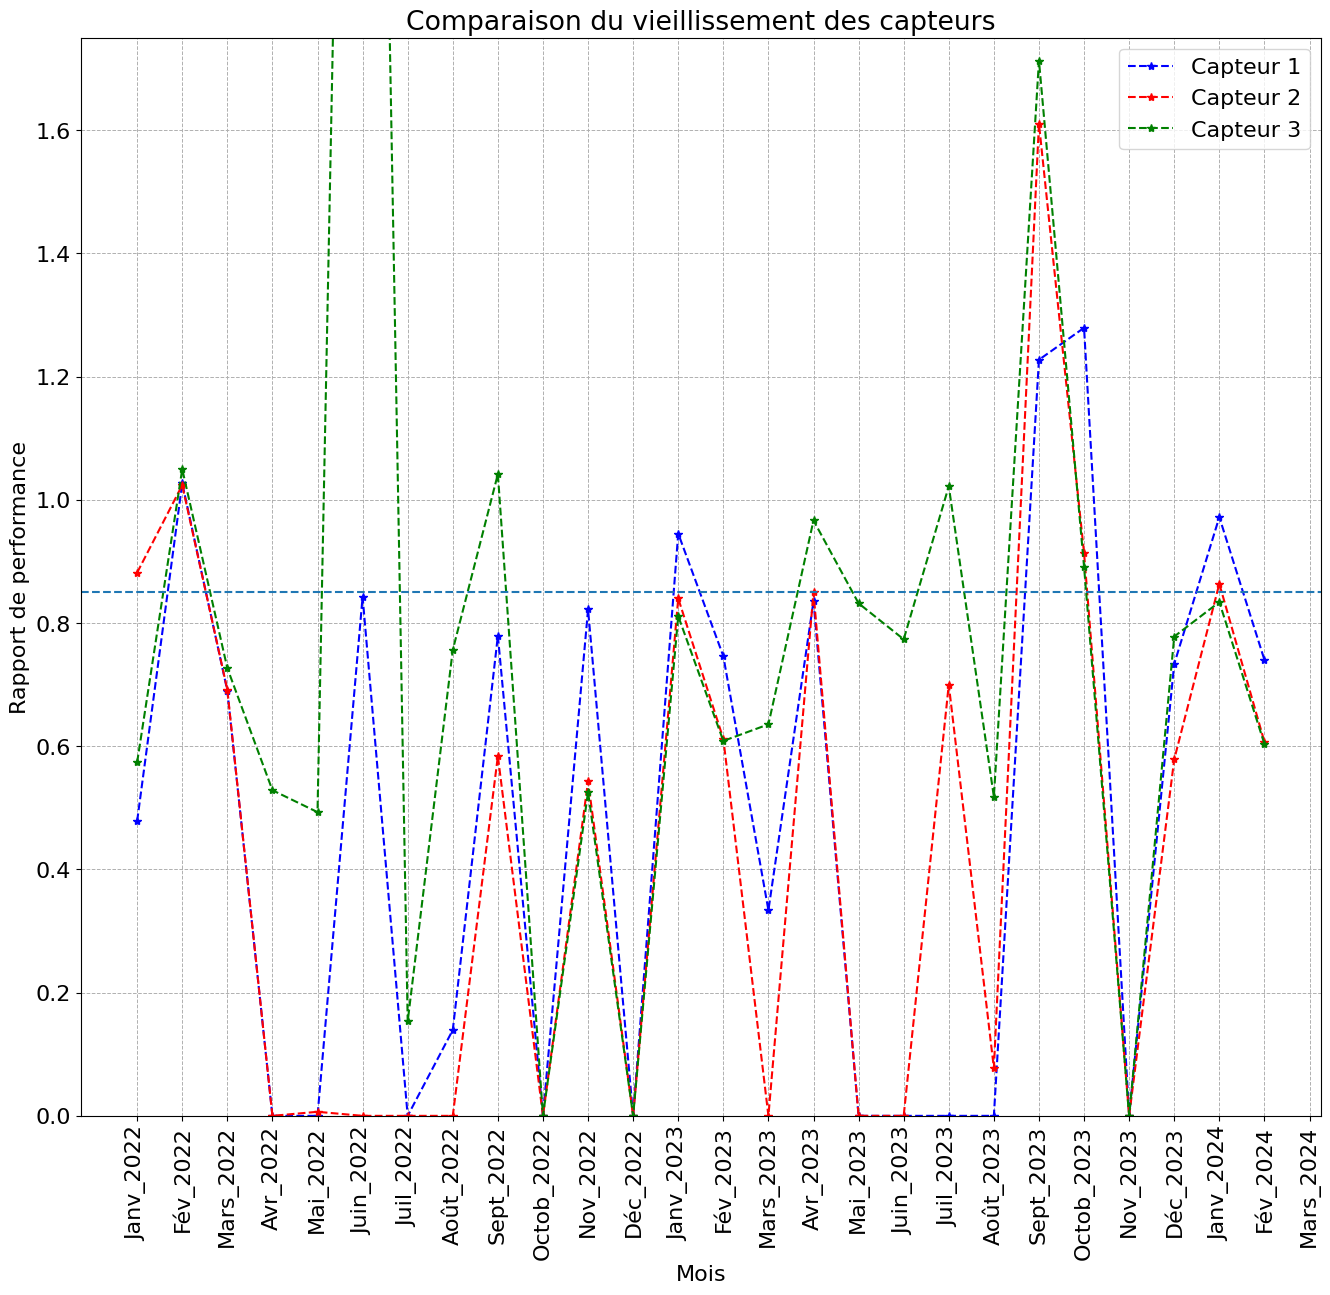

In [159]:
non_score_4['Mois_Année'] = non_score_4['Mois_Année'].replace({eng: fr for eng, fr in month_mapping.items()}, regex=True)
plt.figure(figsize=(16,14))

plt.plot(non_score_4.loc[non_score_4['Model']=='Randomforest']['Mois_Année'],(crois_cap.loc[crois_cap['Mesure'] == mesure_1, 'score'].reset_index(drop=True) / non_score_4.loc[non_score_4['Model'] == 'Randomforest', 'score'].reset_index(drop=True)),'b--*',label='Capteur 1')
plt.plot(non_score_4.loc[non_score_4['Model']=='Randomforest']['Mois_Année'],(crois_cap.loc[crois_cap['Mesure'] == mesure_2, 'score'].reset_index(drop=True) / non_score_4.loc[non_score_4['Model'] == 'Randomforest', 'score'].reset_index(drop=True)),'r--*',label='Capteur 2')
plt.plot(non_score_4.loc[non_score_4['Model']=='Randomforest']['Mois_Année'],(crois_cap.loc[crois_cap['Mesure'] == mesure_3, 'score'].reset_index(drop=True) / non_score_4.loc[non_score_4['Model'] == 'Randomforest', 'score'].reset_index(drop=True)),'g--*',label='Capteur 3')

plt.ylim((0,1.75))
plt.axhline(y=0.85, linestyle='--')
plt.legend()
plt.xlabel('Mois')
plt.ylabel('Rapport de performance')
plt.title('Comparaison du vieillissement des capteurs')
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 16})
plt.markersize = 6
plt.linewidth = 1.5
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.show()

In [ ]:
(crois_cap1.loc[crois_cap1['Mesure'] == mesure_2, 'score'].reset_index(drop=True) / non_scores_1.loc[non_scores_1['Model'] == 'Randomforest', 'score'].reset_index(drop=True))


In [ ]:
crois_1 = train_cap1_test_cap2(data_2021,meteo_api_2021,mesure_2,mesure_1,mesure_3)
crois_2 = train_cap1_test_cap2(data_2022,meteo_api_2022,mesure_2,mesure_1,mesure_3)
crois_3 = train_cap1_test_cap2(data_2023,meteo_api_2023,mesure_2,mesure_1,mesure_3)
crois_cap2 = pd.concat([crois_1,crois_2,crois_3])
month_mapping = {
    "January": "Janvier",
    "February": "Février",
    "March": "Mars",
    "April": "Avril",
    "May": "Mai",
    "June": "Juin",
    "July": "Juillet",
    "August": "Août",
    "September": "Septembre",
    "October": "Octobre",
    "November": "Novembre",
    "December": "Décembre"
}
# Remplacer les mois en anglais par ceux en français
crois_cap2['Mois_Année'] = crois_cap2['Mois_Année'].replace({eng: fr  for eng, fr in month_mapping.items()}, regex=True)
non_scores_2['Mois_Année'] = non_scores_2['Mois_Année'].replace({eng: fr for eng, fr in month_mapping.items()}, regex=True)
plt.figure(figsize=(16,14))
plt.plot(non_scores_2.loc[non_scores_2['Model']=='Randomforest']['Mois_Année'],non_scores_2.loc[non_scores_2['Model']=='Randomforest']['score'],'g--*',label='Capteur 2')
plt.ylim(-1.05,1.05)
plt.plot(crois_cap2.loc[crois_cap2['Mesure']==mesure_1]['Mois_Année'],crois_cap2.loc[crois_cap2['Mesure']==mesure_1]['score'],'b--*',label='Capteur 1')
plt.ylim(-1.05,1.05)
plt.plot(crois_cap2.loc[crois_cap2['Mesure']==mesure_3]['Mois_Année'],crois_cap2.loc[crois_cap2['Mesure']==mesure_3]['score'],'r--*',label='Capteur 3')
plt.ylim(-1.05,1.05)

plt.axhline(y=0.7)
plt.legend()
plt.xlabel('Mois')
plt.ylabel('r²')
plt.title('Application des paramétres de calibration du capteur 2 sur les capteurs 1 et 3')
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 16})
plt.markersize = 10
plt.linewidth = 2
plt.ylim(-1.05,1.05)
plt.grid()
plt.show()

In [ ]:
crois_1 = train_cap1_test_cap2(data_2021,meteo_api_2021,mesure_3,mesure_1,mesure_2)
crois_2 = train_cap1_test_cap2(data_2022,meteo_api_2022,mesure_3,mesure_1,mesure_2)
crois_3 = train_cap1_test_cap2(data_2023,meteo_api_2023,mesure_3,mesure_1,mesure_2)
crois_cap3 = pd.concat([crois_1,crois_2,crois_3])
month_mapping = {
    "January": "Janvier",
    "February": "Février",
    "March": "Mars",
    "April": "Avril",
    "May": "Mai",
    "June": "Juin",
    "July": "Juillet",
    "August": "Août",
    "September": "Septembre",
    "October": "Octobre",
    "November": "Novembre",
    "December": "Décembre"
}
# Remplacer les mois en anglais par ceux en français
crois_cap3['Mois_Année'] = crois_cap3['Mois_Année'].replace({eng: fr  for eng, fr in month_mapping.items()}, regex=True)
non_scores_3['Mois_Année'] = non_scores_3['Mois_Année'].replace({eng: fr for eng, fr in month_mapping.items()}, regex=True)
plt.figure(figsize=(16,14))
plt.plot(non_scores_3.loc[non_scores_3['Model']=='Randomforest']['Mois_Année'],non_scores_3.loc[non_scores_3['Model']=='Randomforest']['score'],'g--*',label='Capteur 2')
plt.ylim(-1.05,1.05)
plt.plot(crois_cap3.loc[crois_cap3['Mesure']==mesure_1]['Mois_Année'],crois_cap3.loc[crois_cap3['Mesure']==mesure_1]['score'],'b--*',label='Capteur 1')
plt.ylim(-1.05,1.05)
plt.plot(crois_cap3.loc[crois_cap3['Mesure']==mesure_2]['Mois_Année'],crois_cap3.loc[crois_cap3['Mesure']==mesure_2]['score'],'r--*',label='Capteur 2')
plt.ylim(-1.05,1.05)
plt.axhline(y=0.7)
plt.legend()
plt.xlabel('Mois')
plt.ylabel('r²')
plt.title('Application des paramétres de calibration du capteur 3 sur les capteurs 1 et 2')
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 16})
plt.markersize = 10
plt.linewidth = 2
plt.grid()
plt.show()

In [ ]:
data_80 = data_complet_cap1.loc[data_complet_cap1['valeur_hum']<=80]
data_80_90 = data_complet_cap1.loc[(data_complet_cap1['valeur_hum']>80) & (data_complet_cap1['valeur_hum']<=90)]
data_90 = data_complet_cap1.loc[data_complet_cap1['valeur_hum']>90]


* Pour mesure = 'FR15043_39_57_3'

In [ ]:
meilleur_model,r2,rmse = apply_model_non_linear(gradboost,X_train,X_test,y_train,y_test, valid = False)

In [ ]:
x = data_80[['valeur_hum','valeur_temp',f'valeur_{mesure_1}']]
y = data_80[['valeur_reference']]
z = meilleur_model.predict(x)
r_2 = r2_score(z,y)
plt.scatter(x[f'valeur_{mesure_1}'],y['valeur_reference'],label=f'RH <= 80% (taux={(len(data_80)/len(data_complet_cap1)):.2f})\n R²={r_2:.2f}')
plt.plot(x[f'valeur_{mesure_1}'],z,label='Randomforest',c='r')
plt.xlabel(f'{mesure_1} PM2.5 (µg/m3)')
plt.ylabel('Reference PM2.5 (µg/m3)')
plt.legend()

In [ ]:
x = data_80_90[['valeur_hum','valeur_temp',f'valeur_{mesure_1}']]
y = data_80_90[['valeur_reference']]
z = meilleur_model.predict(x)
r_2 = r2_score(z,y)
plt.scatter(x[f'valeur_{mesure_1}'],y['valeur_reference'],label=f'80% <= RH <= 90% (taux={(len(data_80_90)/len(data_complet_cap1)):.2f})\n R²={r_2:.2f}')
plt.plot(x[f'valeur_{mesure_1}'],z,label='Randomforest',c='r')
plt.xlabel(f'{mesure_1} PM2.5 (µg/m3)')
plt.ylabel('Reference PM2.5 (µg/m3)')
plt.legend()

In [ ]:
x = data_90[['valeur_hum','valeur_temp',f'valeur_{mesure_1}']]
y = data_90[['valeur_reference']]
z = meilleur_model.predict(x)
r_2 = r2_score(z,y)
plt.scatter(x[f'valeur_{mesure_1}'],y['valeur_reference'],label=f'RH >= 90% (taux={(len(data_90)/len(data_complet_cap1)):.2f})\n R²={r_2:.2f}')
plt.plot(x[f'valeur_{mesure_1}'],z,label='Randomforest',c='r')
plt.xlabel(f'{mesure_1} PM2.5 (µg/m3)')
plt.ylabel('Reference PM2.5 (µg/m3)')
plt.legend()